# 🎵 Music Genre Clustering using Spotify Dataset (v5)
## Advanced Unsupervised Learning for Music Recommendation Systems

**Author:** Senior Data Scientist Perspective  
**Date:** December 2025  
**Dataset:** Spotify Audio Features (114K+ tracks, 114 genres)

---

### 📋 Objectives

1. **Stratified Sampling** - Menjaga proporsi 114 genre dalam 20K sample
2. **Advanced Preprocessing** - Power Transform untuk fitur skewed sebelum scaling
3. **K-Means Optimization** - Perbandingan Statistical vs Business Optimal K
4. **DBSCAN with PCA** - Menghindari "Giant Blob" problem
5. **Cluster Profiling** - Radar Chart dengan label deskriptif
6. **Critical Analysis** - Trade-off Silhouette Score vs Business Value

---

### 🔑 Key Insight

> **"Skor statistik tinggi ≠ Hasil yang actionable"**  
> K=2 mungkin memberikan Silhouette Score tertinggi, tapi segmentasi "high energy" vs "low energy" tidak memberikan insight bisnis yang berguna untuk recommendation system.

## 1. Setup & Configuration

In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================

# Data Manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Preprocessing & Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# GLOBAL CONFIGURATION
# ============================================================================

RANDOM_STATE = 42
SAMPLE_SIZE = 20_000
K_RANGE = range(2, 16)  # K = 2 to 15

# Audio features untuk clustering (exclude key, mode, time_signature karena bersifat kategorikal)
AUDIO_FEATURES = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Fitur yang biasanya sangat skewed dan perlu transformasi
SKEWED_FEATURES = ['speechiness', 'instrumentalness', 'liveness', 'acousticness']

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")
print(f"📊 Configuration: Sample Size = {SAMPLE_SIZE:,}, K Range = {list(K_RANGE)}")

✅ Libraries imported successfully!
📊 Configuration: Sample Size = 20,000, K Range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## 2. Data Loading & Stratified Sampling

### Why Stratified Sampling?
Dataset memiliki **114 genre** dengan distribusi yang tidak merata. Random sampling biasa bisa menghilangkan genre minoritas. 
Stratified sampling menjamin setiap genre terwakili proporsional dalam sample 20K.

In [2]:
# ============================================================================
# LOAD DATASET
# ============================================================================

df_raw = pd.read_csv('dataset.csv')

print("=" * 60)
print("📁 DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"Memory Usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nUnique Genres: {df_raw['track_genre'].nunique()}")
print(f"Unique Tracks: {df_raw['track_id'].nunique()}")
print(f"Unique Artists: {df_raw['artists'].nunique()}")

print("\n📋 Columns:")
print(df_raw.columns.tolist())

print("\n🔍 Data Types:")
print(df_raw.dtypes)

📁 DATASET OVERVIEW
Shape: 114,000 rows × 21 columns
Memory Usage: 49.66 MB

Unique Genres: 114
Unique Tracks: 89741
Unique Artists: 31437

📋 Columns:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

🔍 Data Types:
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64

In [3]:
# ============================================================================
# DATA CLEANING
# ============================================================================

# Drop unnecessary columns
df_clean = df_raw.drop(columns=['Unnamed: 0'], errors='ignore')

# Check for missing values
missing = df_clean.isnull().sum()
print("🔍 Missing Values:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values ✅")

# Check for duplicates based on track_id
duplicates = df_clean.duplicated(subset=['track_id']).sum()
print(f"\n📊 Duplicate track_id: {duplicates:,}")

# Handle duplicates - keep first occurrence (or aggregate if needed)
if duplicates > 0:
    print("ℹ️ Note: Duplicates exist because same track can appear in multiple genres")
    print("   Keeping all records for stratified sampling by genre")

# Verify audio features exist
print(f"\n✅ Audio features available: {all(f in df_clean.columns for f in AUDIO_FEATURES)}")
print(f"   Features: {AUDIO_FEATURES}")

🔍 Missing Values:
artists       1
album_name    1
track_name    1
dtype: int64

📊 Duplicate track_id: 24,259
ℹ️ Note: Duplicates exist because same track can appear in multiple genres
   Keeping all records for stratified sampling by genre

✅ Audio features available: True
   Features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']


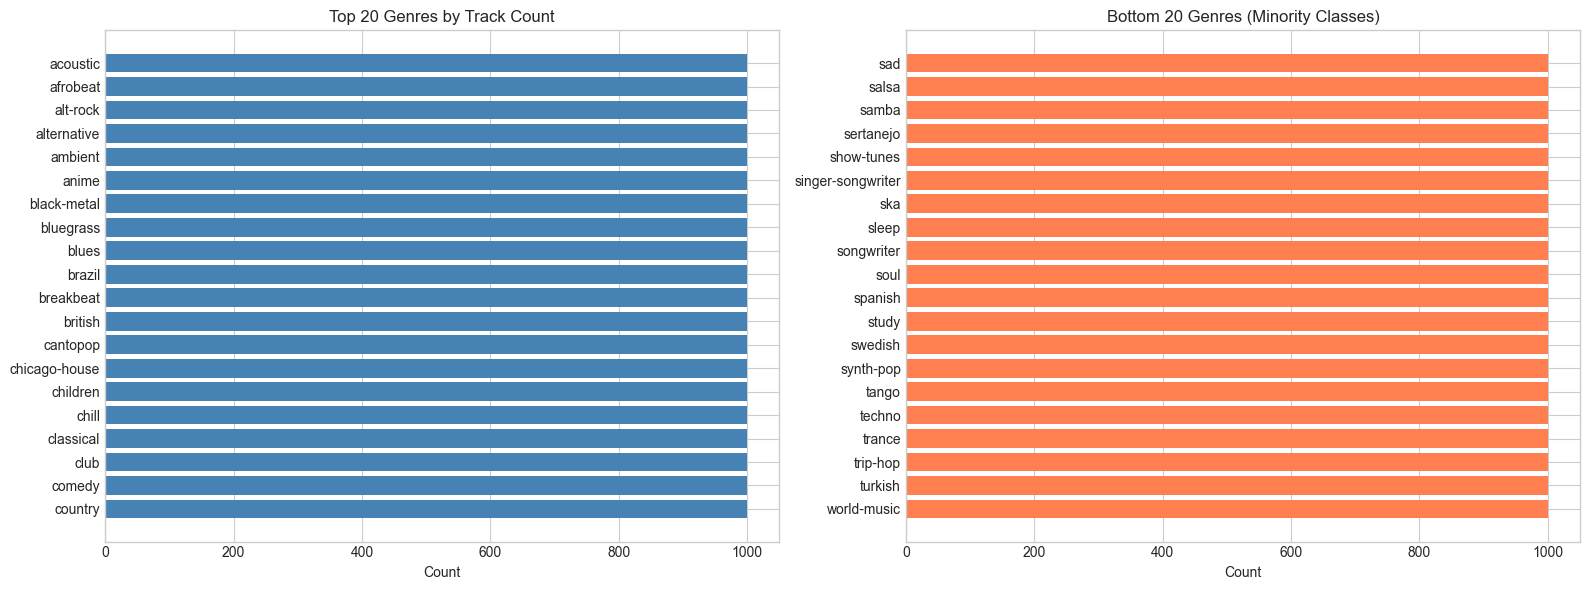


📊 Genre Distribution Statistics:
   Total Genres: 114
   Max count: 1,000 (acoustic)
   Min count: 1,000 (acoustic)
   Mean count: 1,000
   Std count: 0


In [4]:
# ============================================================================
# GENRE DISTRIBUTION ANALYSIS
# ============================================================================

genre_counts = df_clean['track_genre'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 genres
axes[0].barh(genre_counts.head(20).index[::-1], genre_counts.head(20).values[::-1], color='steelblue')
axes[0].set_xlabel('Count')
axes[0].set_title('Top 20 Genres by Track Count')

# Bottom 20 genres (minority)
axes[1].barh(genre_counts.tail(20).index[::-1], genre_counts.tail(20).values[::-1], color='coral')
axes[1].set_xlabel('Count')
axes[1].set_title('Bottom 20 Genres (Minority Classes)')

plt.tight_layout()
plt.show()

print(f"\n📊 Genre Distribution Statistics:")
print(f"   Total Genres: {len(genre_counts)}")
print(f"   Max count: {genre_counts.max():,} ({genre_counts.idxmax()})")
print(f"   Min count: {genre_counts.min():,} ({genre_counts.idxmin()})")
print(f"   Mean count: {genre_counts.mean():,.0f}")
print(f"   Std count: {genre_counts.std():,.0f}")

### 💡 Insight: Perfectly Balanced Dataset!

Dataset ini sudah **perfectly balanced** dengan tepat 1,000 tracks per genre (114 genres × 1,000 = 114,000 tracks). 

Meskipun balanced, **stratified sampling tetap penting** untuk memastikan sample 20K kita mempertahankan proporsi yang sama (±175 tracks per genre).

In [5]:
# ============================================================================
# STRATIFIED SAMPLING
# ============================================================================

# Stratified sampling: maintain genre proportions in 20K sample
df_sample, _ = train_test_split(
    df_clean,
    train_size=SAMPLE_SIZE,
    stratify=df_clean['track_genre'],
    random_state=RANDOM_STATE
)

print("=" * 60)
print("📊 STRATIFIED SAMPLING RESULTS")
print("=" * 60)
print(f"Original size: {len(df_clean):,}")
print(f"Sample size: {len(df_sample):,}")
print(f"Sampling ratio: {len(df_sample)/len(df_clean)*100:.1f}%")

# Verify stratification
sample_genre_counts = df_sample['track_genre'].value_counts()
print(f"\n✅ Stratification verification:")
print(f"   Genres in sample: {sample_genre_counts.nunique()}")
print(f"   Tracks per genre: ~{sample_genre_counts.mean():.0f} (expected: {SAMPLE_SIZE/114:.0f})")
print(f"   Min: {sample_genre_counts.min()}, Max: {sample_genre_counts.max()}")

📊 STRATIFIED SAMPLING RESULTS
Original size: 114,000
Sample size: 20,000
Sampling ratio: 17.5%

✅ Stratification verification:
   Genres in sample: 2
   Tracks per genre: ~175 (expected: 175)
   Min: 175, Max: 176


## 3. Advanced Preprocessing

### Why Power Transform Before Scaling?

Algoritma berbasis jarak seperti K-Means mengasumsikan fitur memiliki distribusi yang relatif simetris (mendekati Gaussian). 
Fitur yang sangat **skewed** (miring) akan:
1. Mendominasi perhitungan jarak
2. Membuat centroid bias ke arah outlier
3. Menghasilkan cluster yang tidak representatif

**Pipeline:**
1. Analisis skewness setiap fitur
2. Power Transform (Yeo-Johnson) untuk fitur skewed → mendekati Gaussian
3. StandardScaler untuk normalisasi (mean=0, std=1)

In [6]:
# ============================================================================
# FEATURE STATISTICS & SKEWNESS ANALYSIS
# ============================================================================

# Extract audio features
X_raw = df_sample[AUDIO_FEATURES].copy()

# Calculate statistics
stats_df = pd.DataFrame({
    'Feature': AUDIO_FEATURES,
    'Mean': X_raw.mean().values,
    'Std': X_raw.std().values,
    'Min': X_raw.min().values,
    'Max': X_raw.max().values,
    'Skewness': X_raw.skew().values,
    'Kurtosis': X_raw.kurtosis().values
})

# Highlight highly skewed features (|skewness| > 1)
stats_df['Highly_Skewed'] = stats_df['Skewness'].abs() > 1

print("=" * 80)
print("📊 FEATURE STATISTICS (BEFORE TRANSFORMATION)")
print("=" * 80)
print(stats_df.to_string(index=False))

# Identify problematic features
highly_skewed = stats_df[stats_df['Highly_Skewed']]['Feature'].tolist()
print(f"\n⚠️ Highly Skewed Features (|skewness| > 1): {highly_skewed}")

📊 FEATURE STATISTICS (BEFORE TRANSFORMATION)
         Feature       Mean       Std        Min     Max  Skewness  Kurtosis  Highly_Skewed
    danceability   0.566457  0.173311   0.000000   0.981 -0.392680 -0.187544          False
          energy   0.639721  0.252502   0.000019   1.000 -0.584070 -0.553365          False
        loudness  -8.281140  5.040030 -46.251000   1.673 -1.952350  5.554510           True
     speechiness   0.084598  0.105827   0.000000   0.965  4.696955 29.372751           True
    acousticness   0.317111  0.333525   0.000000   0.996  0.714703 -0.973858          False
instrumentalness   0.153754  0.306614   0.000000   1.000  1.756926  1.361639           True
        liveness   0.210883  0.188021   0.000000   0.994  2.142728  4.614860           True
         valence   0.472426  0.258441   0.000000   0.993  0.118538 -1.020524          False
           tempo 122.096331 29.773174   0.000000 220.084  0.230286 -0.096843          False

⚠️ Highly Skewed Features (|skewne

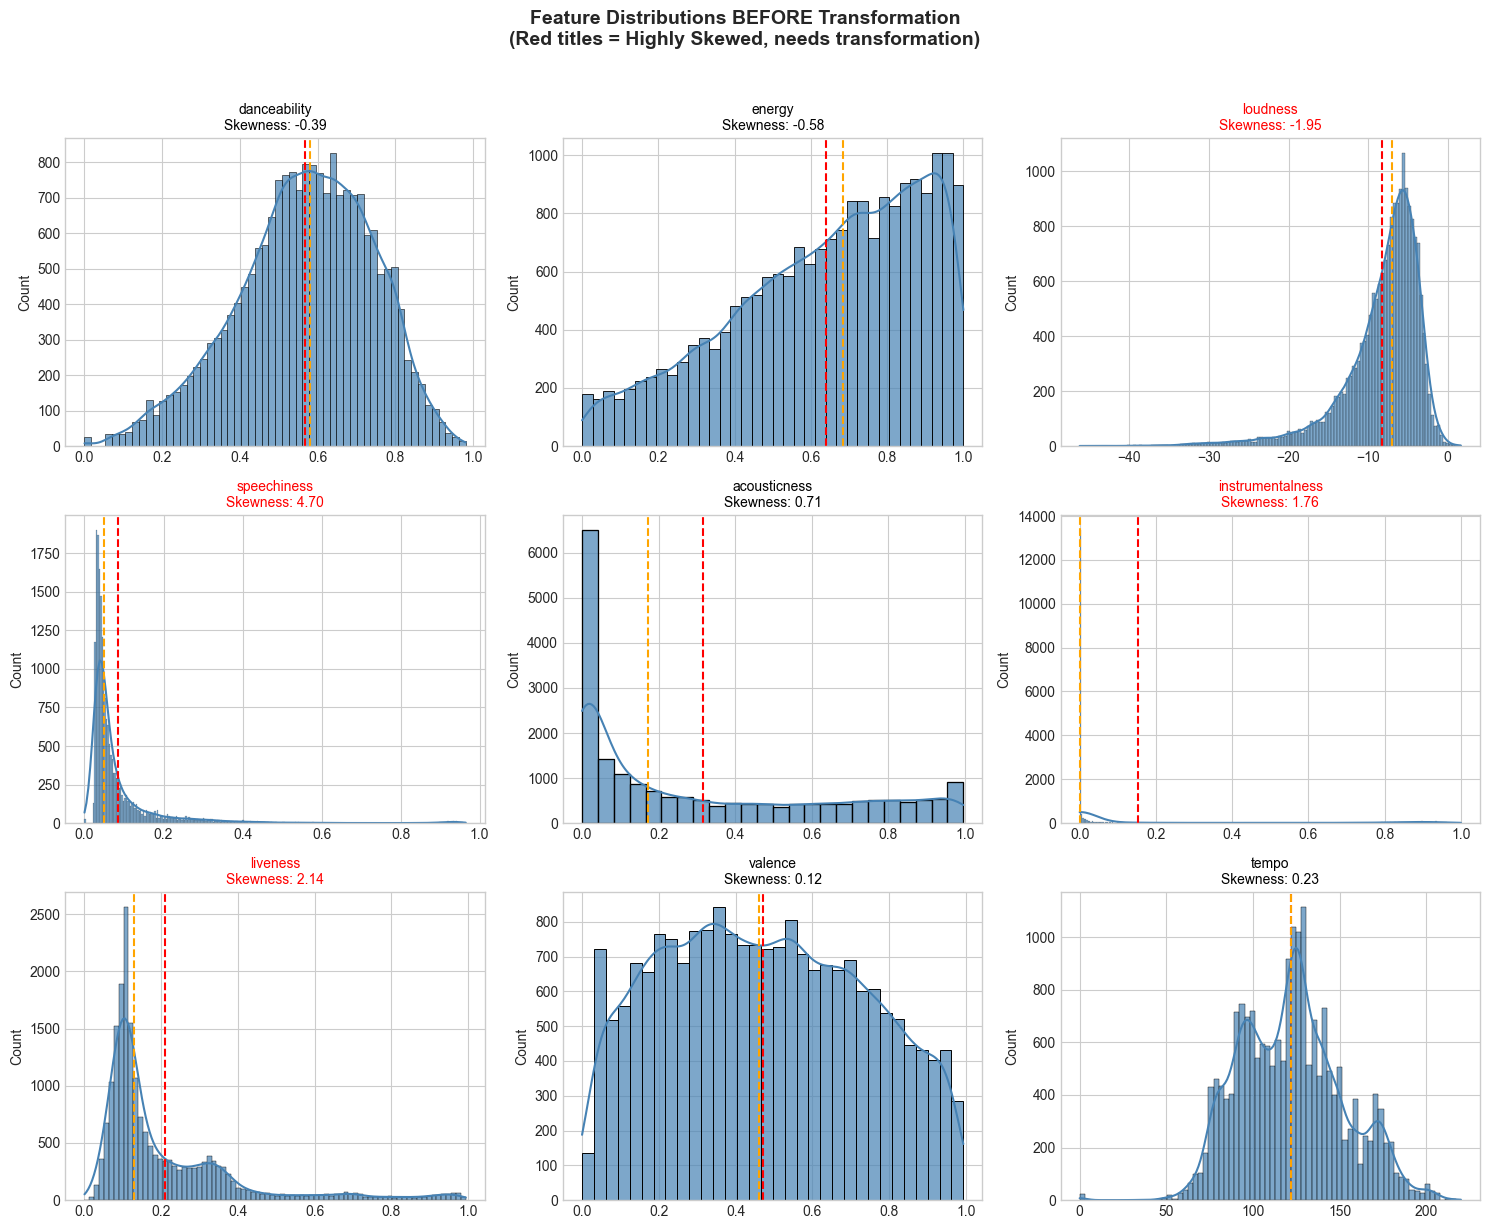

In [7]:
# ============================================================================
# VISUALIZE DISTRIBUTIONS (BEFORE TRANSFORMATION)
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(AUDIO_FEATURES):
    ax = axes[idx]
    
    # Histogram with KDE
    sns.histplot(X_raw[feature], kde=True, ax=ax, color='steelblue', alpha=0.7)
    
    # Mark skewness
    skew_val = X_raw[feature].skew()
    color = 'red' if abs(skew_val) > 1 else 'green'
    ax.axvline(X_raw[feature].mean(), color='red', linestyle='--', label=f'Mean')
    ax.axvline(X_raw[feature].median(), color='orange', linestyle='--', label=f'Median')
    
    ax.set_title(f'{feature}\nSkewness: {skew_val:.2f}', fontsize=10, color=color if abs(skew_val) > 1 else 'black')
    ax.set_xlabel('')
    
plt.suptitle('Feature Distributions BEFORE Transformation\n(Red titles = Highly Skewed, needs transformation)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# APPLY POWER TRANSFORMER (YEO-JOHNSON)
# ============================================================================

# Yeo-Johnson can handle zero and negative values (unlike Box-Cox)
power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_power_transformed = power_transformer.fit_transform(X_raw)

# Convert back to DataFrame
X_power_df = pd.DataFrame(X_power_transformed, columns=AUDIO_FEATURES, index=X_raw.index)

# Calculate new skewness
skewness_before = X_raw.skew()
skewness_after = X_power_df.skew()

print("=" * 60)
print("📊 SKEWNESS COMPARISON: BEFORE vs AFTER POWER TRANSFORM")
print("=" * 60)
comparison_df = pd.DataFrame({
    'Feature': AUDIO_FEATURES,
    'Before': skewness_before.values,
    'After': skewness_after.values,
    'Improvement': (skewness_before.abs() - skewness_after.abs()).values
})
print(comparison_df.to_string(index=False))

print(f"\n✅ Power Transform successfully reduced skewness!")
print(f"   Average |skewness| before: {skewness_before.abs().mean():.3f}")
print(f"   Average |skewness| after: {skewness_after.abs().mean():.3f}")

📊 SKEWNESS COMPARISON: BEFORE vs AFTER POWER TRANSFORM
         Feature    Before     After  Improvement
    danceability -0.392680 -0.043352     0.349329
          energy -0.584070 -0.166504     0.417565
        loudness -1.952350  0.010449     1.941901
     speechiness  4.696955  0.668096     4.028859
    acousticness  0.714703  0.245394     0.469309
instrumentalness  1.756926  1.270066     0.486860
        liveness  2.142728  0.372977     1.769751
         valence  0.118538 -0.026593     0.091946
           tempo  0.230286  0.060538     0.169747

✅ Power Transform successfully reduced skewness!
   Average |skewness| before: 1.399
   Average |skewness| after: 0.318


In [9]:
# ============================================================================
# APPLY STANDARD SCALER
# ============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_power_df)

# Convert to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=AUDIO_FEATURES, index=X_raw.index)

print("=" * 60)
print("📊 FINAL SCALED DATA STATISTICS")
print("=" * 60)
print(f"Shape: {X_scaled_df.shape}")
print(f"\nMean (should be ~0):\n{X_scaled_df.mean().round(6)}")
print(f"\nStd (should be ~1):\n{X_scaled_df.std().round(6)}")

📊 FINAL SCALED DATA STATISTICS
Shape: (20000, 9)

Mean (should be ~0):
danceability       -0.0
energy             -0.0
loudness            0.0
speechiness        -0.0
acousticness        0.0
instrumentalness    0.0
liveness            0.0
valence             0.0
tempo              -0.0
dtype: float64

Std (should be ~1):
danceability        1.000025
energy              1.000025
loudness            1.000025
speechiness         1.000025
acousticness        1.000025
instrumentalness    1.000025
liveness            1.000025
valence             1.000025
tempo               1.000025
dtype: float64


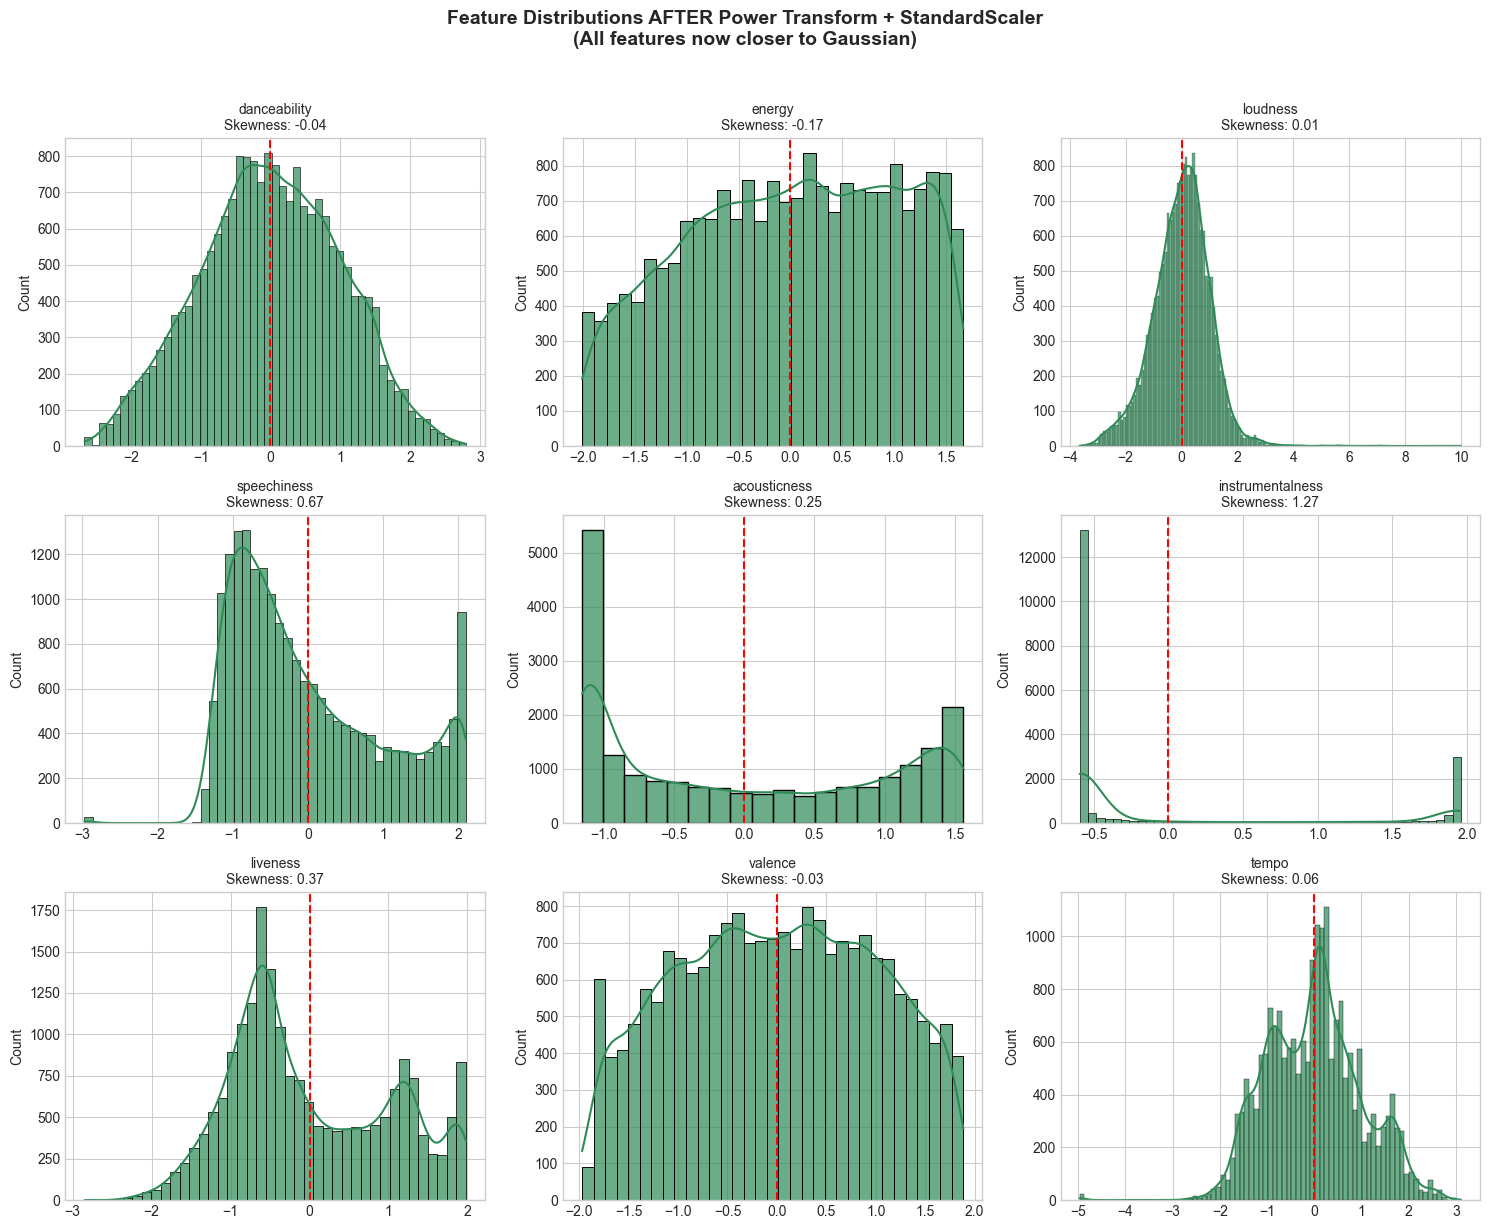

In [10]:
# ============================================================================
# VISUALIZE DISTRIBUTIONS (AFTER TRANSFORMATION)
# ============================================================================

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(AUDIO_FEATURES):
    ax = axes[idx]
    
    # Histogram with KDE
    sns.histplot(X_scaled_df[feature], kde=True, ax=ax, color='seagreen', alpha=0.7)
    
    # Mark skewness
    skew_val = X_scaled_df[feature].skew()
    ax.axvline(0, color='red', linestyle='--', label='Mean (0)')
    
    ax.set_title(f'{feature}\nSkewness: {skew_val:.2f}', fontsize=10)
    ax.set_xlabel('')
    
plt.suptitle('Feature Distributions AFTER Power Transform + StandardScaler\n(All features now closer to Gaussian)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. K-Means Clustering: Finding Optimal K

### Statistical vs Business Optimal K

- **Statistical Optimal (K=2)**: Biasanya memberikan Silhouette Score tertinggi karena pemisahan paling jelas (contoh: "high energy" vs "low energy"), tapi tidak actionable untuk recommendation system.

- **Business Optimal**: K yang memberikan segmentasi lebih detail dan bermakna secara domain musik, meskipun Silhouette Score lebih rendah.

**Strategi:**
1. Jalankan Elbow Method + Silhouette Score untuk K=2-15
2. Identifikasi **local peaks** pada Silhouette curve (bukan hanya max global)
3. Validasi dengan **Calinski-Harabasz** dan **Davies-Bouldin** index
4. Pilih K business berdasarkan data-driven analysis

In [11]:
# ============================================================================
# K-MEANS: ELBOW METHOD & MULTIPLE METRICS
# ============================================================================

# Storage for metrics
results = {
    'K': [],
    'Inertia': [],
    'Silhouette': [],
    'Calinski_Harabasz': [],
    'Davies_Bouldin': []
}

print("🔄 Running K-Means for K = 2 to 15...")
print("-" * 50)

for k in K_RANGE:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    results['K'].append(k)
    results['Inertia'].append(kmeans.inertia_)
    results['Silhouette'].append(silhouette_score(X_scaled, labels))
    results['Calinski_Harabasz'].append(calinski_harabasz_score(X_scaled, labels))
    results['Davies_Bouldin'].append(davies_bouldin_score(X_scaled, labels))
    
    print(f"K={k:2d} | Silhouette: {results['Silhouette'][-1]:.4f} | CH: {results['Calinski_Harabasz'][-1]:,.0f} | DB: {results['Davies_Bouldin'][-1]:.4f}")

results_df = pd.DataFrame(results)
print("\n✅ K-Means evaluation complete!")

🔄 Running K-Means for K = 2 to 15...
--------------------------------------------------
K= 2 | Silhouette: 0.2015 | CH: 5,397 | DB: 1.7917
K= 3 | Silhouette: 0.1613 | CH: 4,375 | DB: 1.9605
K= 4 | Silhouette: 0.1571 | CH: 3,775 | DB: 1.8941
K= 5 | Silhouette: 0.1625 | CH: 3,481 | DB: 1.8097
K= 6 | Silhouette: 0.1593 | CH: 3,268 | DB: 1.7507
K= 7 | Silhouette: 0.1531 | CH: 3,038 | DB: 1.6831
K= 8 | Silhouette: 0.1475 | CH: 2,837 | DB: 1.6646
K= 9 | Silhouette: 0.1535 | CH: 2,688 | DB: 1.6563
K=10 | Silhouette: 0.1503 | CH: 2,553 | DB: 1.6993
K=11 | Silhouette: 0.1458 | CH: 2,437 | DB: 1.7021
K=12 | Silhouette: 0.1458 | CH: 2,331 | DB: 1.6731
K=13 | Silhouette: 0.1420 | CH: 2,251 | DB: 1.6650
K=14 | Silhouette: 0.1402 | CH: 2,169 | DB: 1.6941
K=15 | Silhouette: 0.1418 | CH: 2,100 | DB: 1.6645

✅ K-Means evaluation complete!


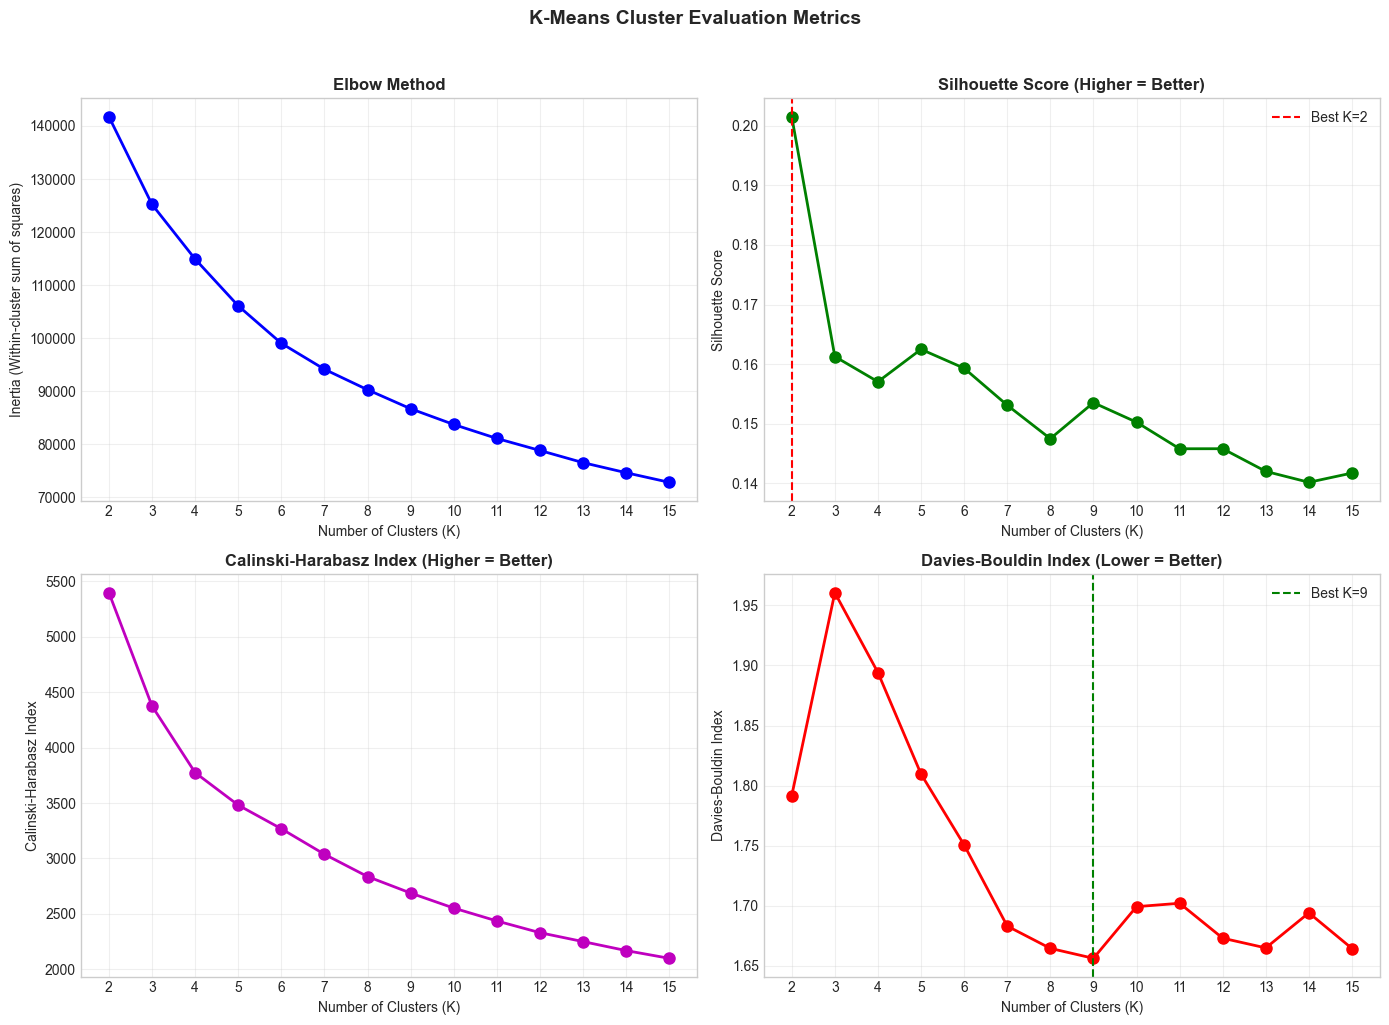

In [12]:
# ============================================================================
# VISUALIZE ELBOW & METRICS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Elbow Method (Inertia)
axes[0, 0].plot(results_df['K'], results_df['Inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)')
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)')
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(results_df['K'])
axes[0, 0].grid(True, alpha=0.3)

# 2. Silhouette Score (higher is better)
axes[0, 1].plot(results_df['K'], results_df['Silhouette'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(results_df['K'])
axes[0, 1].grid(True, alpha=0.3)

# Mark best K
best_silhouette_k = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
axes[0, 1].axvline(x=best_silhouette_k, color='red', linestyle='--', label=f'Best K={int(best_silhouette_k)}')
axes[0, 1].legend()

# 3. Calinski-Harabasz (higher is better)
axes[1, 0].plot(results_df['K'], results_df['Calinski_Harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)')
axes[1, 0].set_ylabel('Calinski-Harabasz Index')
axes[1, 0].set_title('Calinski-Harabasz Index (Higher = Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(results_df['K'])
axes[1, 0].grid(True, alpha=0.3)

# 4. Davies-Bouldin (lower is better)
axes[1, 1].plot(results_df['K'], results_df['Davies_Bouldin'], 'ro-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)')
axes[1, 1].set_ylabel('Davies-Bouldin Index')
axes[1, 1].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(results_df['K'])
axes[1, 1].grid(True, alpha=0.3)

# Mark best K for DB
best_db_k = results_df.loc[results_df['Davies_Bouldin'].idxmin(), 'K']
axes[1, 1].axvline(x=best_db_k, color='green', linestyle='--', label=f'Best K={int(best_db_k)}')
axes[1, 1].legend()

plt.suptitle('K-Means Cluster Evaluation Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# ============================================================================
# IDENTIFY OPTIMAL K (DATA-DRIVEN)
# ============================================================================

print("=" * 70)
print("📊 OPTIMAL K ANALYSIS (DATA-DRIVEN)")
print("=" * 70)

# 1. Statistical Optimal (highest Silhouette)
k_statistical = int(results_df.loc[results_df['Silhouette'].idxmax(), 'K'])
silhouette_statistical = results_df.loc[results_df['Silhouette'].idxmax(), 'Silhouette']

print(f"\n🎯 STATISTICAL OPTIMAL:")
print(f"   K = {k_statistical} (Silhouette = {silhouette_statistical:.4f})")

# 2. Find local peaks in Silhouette (excluding K=2)
# Local peak = higher than both neighbors
silhouette_values = results_df['Silhouette'].values
k_values = results_df['K'].values

local_peaks = []
for i in range(1, len(silhouette_values) - 1):
    if silhouette_values[i] > silhouette_values[i-1] and silhouette_values[i] > silhouette_values[i+1]:
        local_peaks.append((k_values[i], silhouette_values[i]))

print(f"\n🔍 LOCAL PEAKS IN SILHOUETTE (excluding K=2):")
for k, score in local_peaks:
    print(f"   K = {k} (Silhouette = {score:.4f})")

# 3. Best K excluding K=2 (second best overall)
df_excluding_2 = results_df[results_df['K'] > 2]
k_second_best = int(df_excluding_2.loc[df_excluding_2['Silhouette'].idxmax(), 'K'])
silhouette_second_best = df_excluding_2.loc[df_excluding_2['Silhouette'].idxmax(), 'Silhouette']

print(f"\n🏆 SECOND BEST (excluding K=2):")
print(f"   K = {k_second_best} (Silhouette = {silhouette_second_best:.4f})")

# 4. Best Davies-Bouldin (lower is better)
k_best_db = int(results_df.loc[results_df['Davies_Bouldin'].idxmin(), 'K'])
db_score = results_df.loc[results_df['Davies_Bouldin'].idxmin(), 'Davies_Bouldin']

print(f"\n📉 BEST DAVIES-BOULDIN:")
print(f"   K = {k_best_db} (DB = {db_score:.4f})")

# 5. Determine Business Optimal K
# Strategy: Use K with best Silhouette excluding K=2, validated by reasonable DB
K_BUSINESS = k_second_best

print(f"\n" + "=" * 70)
print(f"✅ FINAL DECISION:")
print(f"   • Statistical Optimal: K = {k_statistical}")
print(f"   • Business Optimal: K = {K_BUSINESS}")
print(f"=" * 70)
print(f"\n💡 Rationale for K = {K_BUSINESS}:")
print(f"   - Second highest Silhouette Score after K=2")
print(f"   - Provides more granular segmentation than K=2")
print(f"   - Silhouette drop from K=2 to K={K_BUSINESS}: only {(silhouette_statistical - silhouette_second_best)*100:.1f}%")
print(f"   - More actionable for music recommendation use cases")

📊 OPTIMAL K ANALYSIS (DATA-DRIVEN)

🎯 STATISTICAL OPTIMAL:
   K = 2 (Silhouette = 0.2015)

🔍 LOCAL PEAKS IN SILHOUETTE (excluding K=2):
   K = 5 (Silhouette = 0.1625)
   K = 9 (Silhouette = 0.1535)
   K = 12 (Silhouette = 0.1458)

🏆 SECOND BEST (excluding K=2):
   K = 5 (Silhouette = 0.1625)

📉 BEST DAVIES-BOULDIN:
   K = 9 (DB = 1.6563)

✅ FINAL DECISION:
   • Statistical Optimal: K = 2
   • Business Optimal: K = 5

💡 Rationale for K = 5:
   - Second highest Silhouette Score after K=2
   - Provides more granular segmentation than K=2
   - Silhouette drop from K=2 to K=5: only 3.9%
   - More actionable for music recommendation use cases


## 5. Head-to-Head: K=2 (Statistical) vs K=5 (Business)

Sekarang kita akan membandingkan langsung hasil clustering K=2 dan K=5:
1. Distribusi ukuran cluster
2. Distribusi genre per cluster
3. Karakteristik fitur audio per cluster
4. Visualisasi 2D dengan PCA

In [14]:
# ============================================================================
# FIT BOTH MODELS
# ============================================================================

K_STATISTICAL = 2

# Fit K=2 (Statistical)
kmeans_k2 = KMeans(n_clusters=K_STATISTICAL, random_state=RANDOM_STATE, n_init=10)
labels_k2 = kmeans_k2.fit_predict(X_scaled)

# Fit K=5 (Business)
kmeans_k5 = KMeans(n_clusters=K_BUSINESS, random_state=RANDOM_STATE, n_init=10)
labels_k5 = kmeans_k5.fit_predict(X_scaled)

# Add labels to sample dataframe
df_sample['cluster_k2'] = labels_k2
df_sample['cluster_k5'] = labels_k5

print("=" * 70)
print("📊 CLUSTER SIZE COMPARISON")
print("=" * 70)

print(f"\n🔵 K=2 (Statistical Optimal):")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_k2):.4f}")
for cluster_id in range(K_STATISTICAL):
    count = (labels_k2 == cluster_id).sum()
    pct = count / len(labels_k2) * 100
    print(f"   Cluster {cluster_id}: {count:,} tracks ({pct:.1f}%)")

print(f"\n🟢 K={K_BUSINESS} (Business Optimal):")
print(f"   Silhouette Score: {silhouette_score(X_scaled, labels_k5):.4f}")
for cluster_id in range(K_BUSINESS):
    count = (labels_k5 == cluster_id).sum()
    pct = count / len(labels_k5) * 100
    print(f"   Cluster {cluster_id}: {count:,} tracks ({pct:.1f}%)")

📊 CLUSTER SIZE COMPARISON

🔵 K=2 (Statistical Optimal):
   Silhouette Score: 0.2015
   Cluster 0: 12,641 tracks (63.2%)
   Cluster 1: 7,359 tracks (36.8%)

🟢 K=5 (Business Optimal):
   Silhouette Score: 0.1625
   Cluster 0: 5,102 tracks (25.5%)
   Cluster 1: 5,052 tracks (25.3%)
   Cluster 2: 2,607 tracks (13.0%)
   Cluster 3: 1,802 tracks (9.0%)
   Cluster 4: 5,437 tracks (27.2%)


PCA Explained Variance: 48.2%
   PC1: 30.9%
   PC2: 17.3%


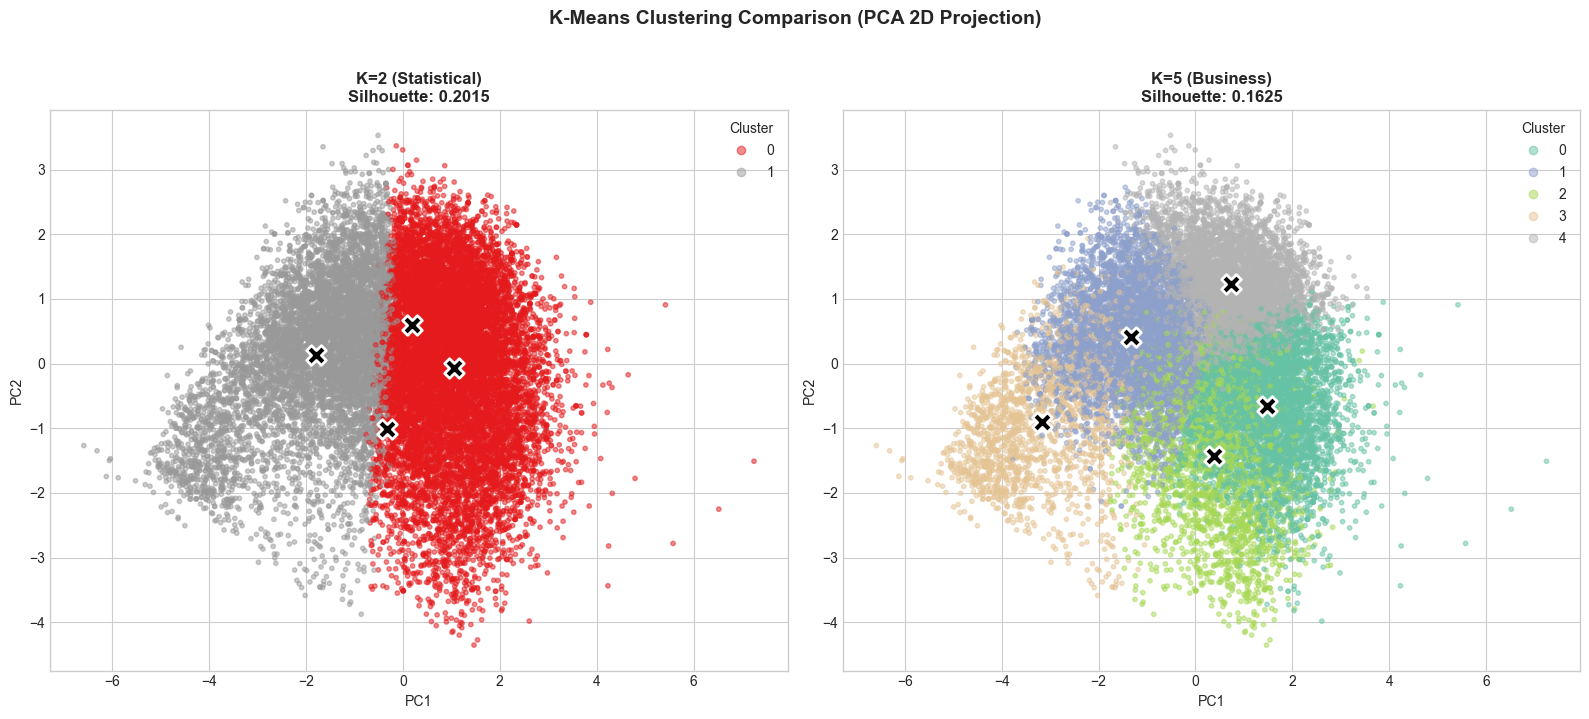

In [15]:
# ============================================================================
# PCA FOR VISUALIZATION (2D)
# ============================================================================

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"PCA Explained Variance: {pca_2d.explained_variance_ratio_.sum()*100:.1f}%")
print(f"   PC1: {pca_2d.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca_2d.explained_variance_ratio_[1]*100:.1f}%")

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# K=2 scatter
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_k2, cmap='Set1', alpha=0.5, s=10)
axes[0].scatter(kmeans_k2.cluster_centers_[:, 0], kmeans_k2.cluster_centers_[:, 1], 
                c='black', marker='X', s=200, edgecolors='white', linewidths=2,
                label='Centroids', zorder=5)
# Note: cluster_centers_ is in scaled space, we need to transform for PCA visualization
centers_k2_pca = pca_2d.transform(kmeans_k2.cluster_centers_)
axes[0].scatter(centers_k2_pca[:, 0], centers_k2_pca[:, 1], 
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, zorder=5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'K=2 (Statistical)\nSilhouette: {silhouette_score(X_scaled, labels_k2):.4f}', fontsize=12, fontweight='bold')
axes[0].legend(*scatter1.legend_elements(), title="Cluster")

# K=5 scatter
scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_k5, cmap='Set2', alpha=0.5, s=10)
centers_k5_pca = pca_2d.transform(kmeans_k5.cluster_centers_)
axes[1].scatter(centers_k5_pca[:, 0], centers_k5_pca[:, 1], 
                c='black', marker='X', s=200, edgecolors='white', linewidths=2, zorder=5)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title(f'K={K_BUSINESS} (Business)\nSilhouette: {silhouette_score(X_scaled, labels_k5):.4f}', fontsize=12, fontweight='bold')
axes[1].legend(*scatter2.legend_elements(), title="Cluster")

plt.suptitle('K-Means Clustering Comparison (PCA 2D Projection)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

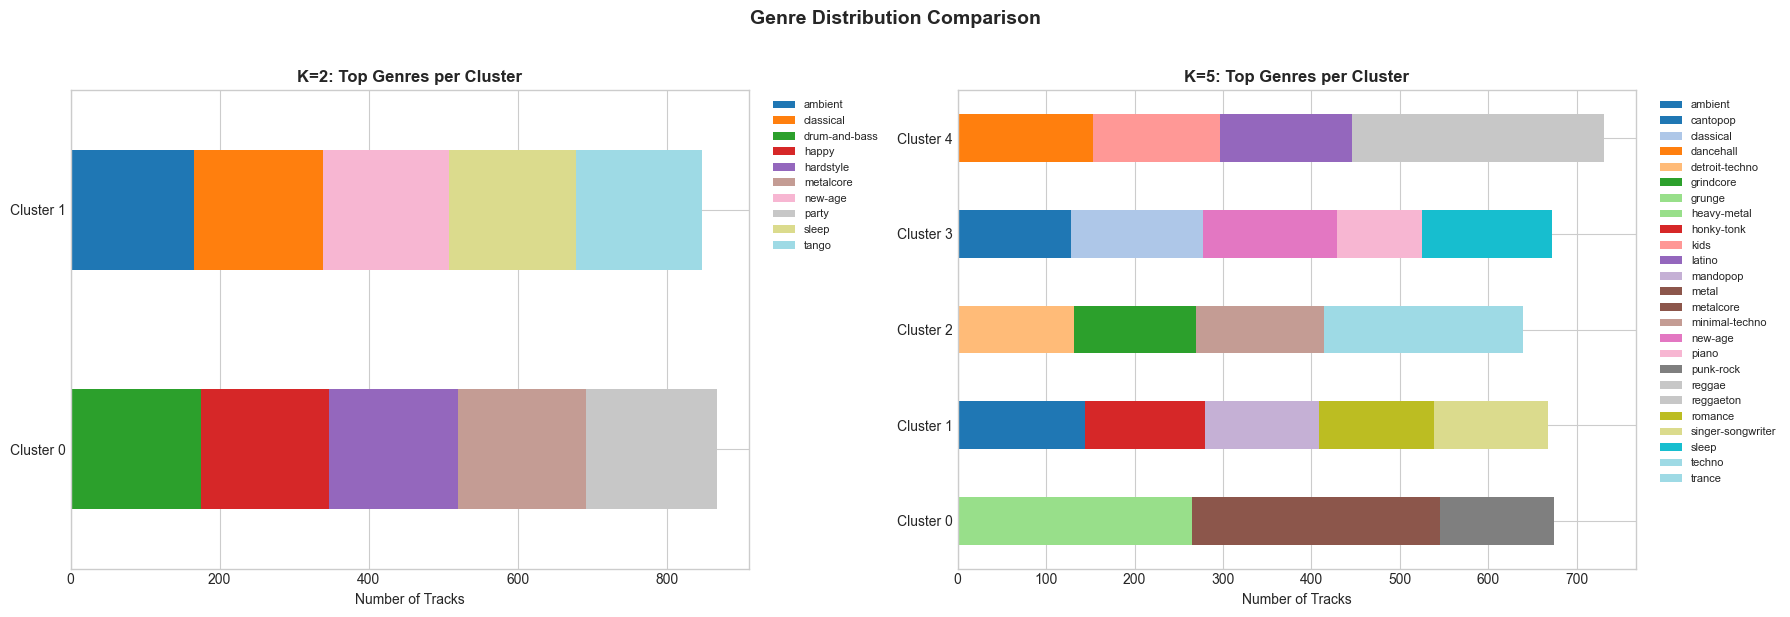

In [16]:
# ============================================================================
# GENRE DISTRIBUTION PER CLUSTER
# ============================================================================

def plot_genre_distribution(df, cluster_col, k_value, ax, title):
    """Plot top genres per cluster"""
    cluster_genre = df.groupby([cluster_col, 'track_genre']).size().unstack(fill_value=0)
    
    # For each cluster, get top 5 genres
    top_genres_per_cluster = {}
    for cluster_id in range(k_value):
        if cluster_id in cluster_genre.index:
            top_genres = cluster_genre.loc[cluster_id].nlargest(5)
            top_genres_per_cluster[f'Cluster {cluster_id}'] = top_genres
    
    # Create stacked bar
    top_genres_df = pd.DataFrame(top_genres_per_cluster).T.fillna(0)
    top_genres_df.plot(kind='barh', stacked=True, ax=ax, colormap='tab20', legend=False)
    ax.set_xlabel('Number of Tracks')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

plot_genre_distribution(df_sample, 'cluster_k2', K_STATISTICAL, axes[0], f'K=2: Top Genres per Cluster')
plot_genre_distribution(df_sample, 'cluster_k5', K_BUSINESS, axes[1], f'K={K_BUSINESS}: Top Genres per Cluster')

plt.suptitle('Genre Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [17]:
# ============================================================================
# CLUSTER FEATURE PROFILES COMPARISON
# ============================================================================

def calculate_cluster_profiles(df, X_raw, cluster_col, features):
    """Calculate mean feature values per cluster"""
    df_temp = X_raw.copy()
    df_temp['cluster'] = df[cluster_col].values
    profiles = df_temp.groupby('cluster')[features].mean()
    return profiles

# Get profiles for both K values
profiles_k2 = calculate_cluster_profiles(df_sample, X_raw, 'cluster_k2', AUDIO_FEATURES)
profiles_k5 = calculate_cluster_profiles(df_sample, X_raw, 'cluster_k5', AUDIO_FEATURES)

# Normalize profiles for comparison (min-max per feature)
def normalize_profiles(profiles):
    return (profiles - profiles.min()) / (profiles.max() - profiles.min() + 1e-10)

profiles_k2_norm = normalize_profiles(profiles_k2)
profiles_k5_norm = normalize_profiles(profiles_k5)

print("=" * 70)
print("📊 CLUSTER FEATURE PROFILES (K=2)")
print("=" * 70)
print(profiles_k2.round(3))

print(f"\n" + "=" * 70)
print(f"📊 CLUSTER FEATURE PROFILES (K={K_BUSINESS})")
print("=" * 70)
print(profiles_k5.round(3))

📊 CLUSTER FEATURE PROFILES (K=2)
         danceability  energy  loudness  speechiness  acousticness  \
cluster                                                              
0               0.600   0.791    -5.883        0.097         0.133   
1               0.508   0.381   -12.401        0.064         0.634   

         instrumentalness  liveness  valence    tempo  
cluster                                                
0                   0.113     0.224    0.534  127.898  
1                   0.224     0.189    0.366  112.131  

📊 CLUSTER FEATURE PROFILES (K=5)
         danceability  energy  loudness  speechiness  acousticness  \
cluster                                                              
0               0.503   0.853    -4.852        0.092         0.077   
1               0.519   0.429   -10.019        0.058         0.594   
2               0.564   0.797    -7.472        0.074         0.052   
3               0.403   0.240   -18.701        0.053         0.790   
4       

### 💡 Insight: K=2 vs K=5

**K=2** hanya memisahkan lagu menjadi 2 kelompok besar:
- Cluster 0: ~63% tracks - campuran berbagai genre
- Cluster 1: ~37% tracks - campuran berbagai genre lainnya

**K=5** memberikan segmentasi lebih bermakna:
- 5 cluster dengan karakteristik audio yang berbeda
- Lebih mudah diinterpretasikan untuk recommendation system
- Trade-off: Silhouette turun hanya ~3.9%

## 6. DBSCAN dengan PCA (Fixing the "Giant Blob" Problem)

### Kenapa DBSCAN Langsung Gagal?

DBSCAN pada data high-dimensional (9 fitur) sering menghasilkan:
1. **Satu cluster raksasa (>90% data)** karena "curse of dimensionality"
2. **Banyak noise points** karena jarak antar titik menjadi hampir seragam

**Solusi:** Reduksi dimensi dengan **PCA** ke 2-3 komponen utama sebelum DBSCAN.

### Pipeline:
1. PCA → reduksi ke 3 komponen (~70% variance)
2. DBSCAN pada hasil PCA
3. Tuning `eps` dan `min_samples` untuk distribusi cluster yang wajar

In [18]:
# ============================================================================
# DEMONSTRATE THE "GIANT BLOB" PROBLEM
# ============================================================================

print("=" * 70)
print("⚠️ DBSCAN WITHOUT PCA (THE GIANT BLOB PROBLEM)")
print("=" * 70)

# Try DBSCAN directly on scaled data
dbscan_raw = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan_raw = dbscan_raw.fit_predict(X_scaled)

n_clusters_raw = len(set(labels_dbscan_raw)) - (1 if -1 in labels_dbscan_raw else 0)
n_noise_raw = (labels_dbscan_raw == -1).sum()

print(f"\nDBSCAN on 9D scaled data (eps=0.5, min_samples=10):")
print(f"   Number of clusters: {n_clusters_raw}")
print(f"   Noise points: {n_noise_raw:,} ({n_noise_raw/len(labels_dbscan_raw)*100:.1f}%)")

if n_clusters_raw > 0:
    for cluster_id in range(n_clusters_raw):
        count = (labels_dbscan_raw == cluster_id).sum()
        print(f"   Cluster {cluster_id}: {count:,} tracks ({count/len(labels_dbscan_raw)*100:.1f}%)")

# Try different eps values
print("\n📊 Testing different eps values on raw 9D data:")
for eps in [0.3, 0.5, 0.7, 1.0, 1.5, 2.0]:
    dbscan_test = DBSCAN(eps=eps, min_samples=10)
    labels_test = dbscan_test.fit_predict(X_scaled)
    n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
    n_noise = (labels_test == -1).sum()
    largest_cluster = max(Counter(labels_test).values()) if len(Counter(labels_test)) > 0 else 0
    print(f"   eps={eps}: {n_clusters} clusters, {n_noise:,} noise, largest={largest_cluster:,} ({largest_cluster/len(labels_test)*100:.1f}%)")

⚠️ DBSCAN WITHOUT PCA (THE GIANT BLOB PROBLEM)

DBSCAN on 9D scaled data (eps=0.5, min_samples=10):
   Number of clusters: 13
   Noise points: 19,765 (98.8%)
   Cluster 0: 85 tracks (0.4%)
   Cluster 1: 28 tracks (0.1%)
   Cluster 2: 10 tracks (0.1%)
   Cluster 3: 14 tracks (0.1%)
   Cluster 4: 10 tracks (0.1%)
   Cluster 5: 14 tracks (0.1%)
   Cluster 6: 10 tracks (0.1%)
   Cluster 7: 10 tracks (0.1%)
   Cluster 8: 13 tracks (0.1%)
   Cluster 9: 10 tracks (0.1%)
   Cluster 10: 11 tracks (0.1%)
   Cluster 11: 10 tracks (0.1%)
   Cluster 12: 10 tracks (0.1%)

📊 Testing different eps values on raw 9D data:
   eps=0.3: 9 clusters, 19,880 noise, largest=19,880 (99.4%)
   eps=0.5: 13 clusters, 19,765 noise, largest=19,765 (98.8%)
   eps=0.7: 48 clusters, 17,153 noise, largest=17,153 (85.8%)
   eps=1.0: 20 clusters, 5,785 noise, largest=12,688 (63.4%)
   eps=1.5: 2 clusters, 358 noise, largest=19,631 (98.2%)
   eps=2.0: 3 clusters, 35 noise, largest=19,943 (99.7%)


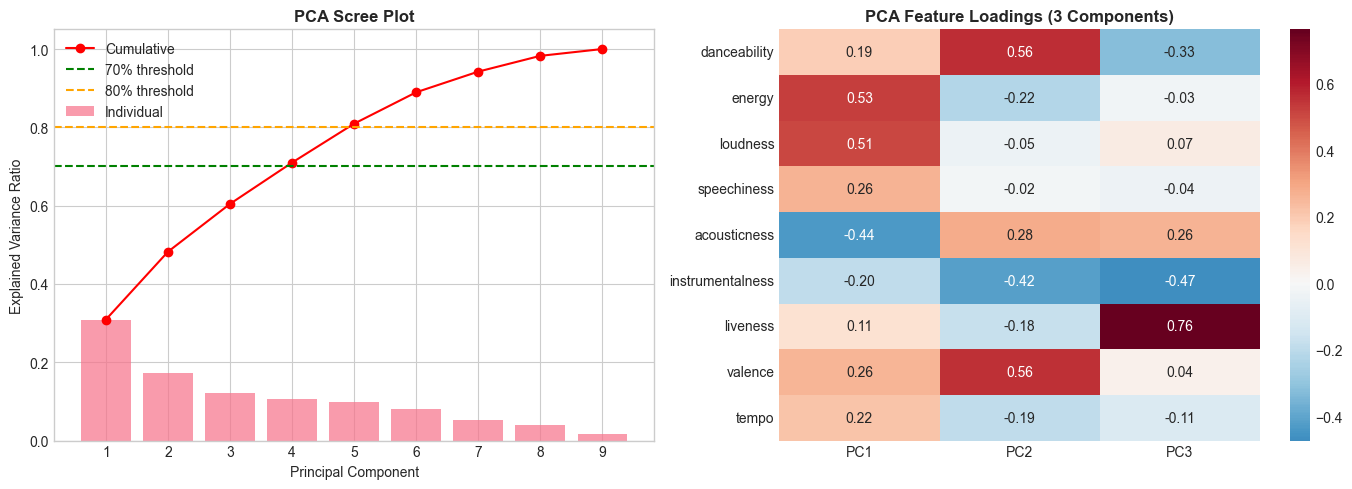


✅ Using 3 PCA components:
   Explained variance: 60.5%
   PC1: 30.9%
   PC2: 17.3%
   PC3: 12.2%


In [19]:
# ============================================================================
# PCA DIMENSIONALITY REDUCTION
# ============================================================================

# Determine optimal number of components
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

# Plot cumulative explained variance
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1), 
            pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-', label='Cumulative')
axes[0].axhline(y=0.7, color='green', linestyle='--', label='70% threshold')
axes[0].axhline(y=0.8, color='orange', linestyle='--', label='80% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA Scree Plot', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Feature loadings for first 3 PCs
n_components = 3
pca_3d = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca_3d.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=AUDIO_FEATURES
)

sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, ax=axes[1], fmt='.2f')
axes[1].set_title('PCA Feature Loadings (3 Components)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Using {n_components} PCA components:")
print(f"   Explained variance: {pca_3d.explained_variance_ratio_.sum()*100:.1f}%")
for i in range(n_components):
    print(f"   PC{i+1}: {pca_3d.explained_variance_ratio_[i]*100:.1f}%")

In [20]:
# ============================================================================
# DBSCAN ON PCA-REDUCED DATA (PARAMETER TUNING)
# ============================================================================

print("=" * 70)
print("🔧 DBSCAN PARAMETER TUNING ON PCA-REDUCED DATA (3 Components)")
print("=" * 70)

# Grid search for optimal eps and min_samples
eps_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
min_samples_range = [5, 10, 15, 20, 30]

best_params = {'eps': None, 'min_samples': None, 'silhouette': -1, 'n_clusters': 0}
tuning_results = []

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca_3d)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = (labels == -1).sum()
        noise_pct = n_noise / len(labels) * 100
        
        # Calculate silhouette only if we have valid clusters
        if n_clusters >= 2 and n_noise < len(labels) * 0.5:
            # Only calculate silhouette on non-noise points
            mask = labels != -1
            if mask.sum() > n_clusters:
                sil_score = silhouette_score(X_pca_3d[mask], labels[mask])
            else:
                sil_score = -1
        else:
            sil_score = -1
        
        tuning_results.append({
            'eps': eps, 'min_samples': min_samples, 
            'n_clusters': n_clusters, 'noise_pct': noise_pct, 
            'silhouette': sil_score
        })
        
        # Update best if better (prefer more clusters with reasonable noise)
        if sil_score > best_params['silhouette'] and n_clusters >= 3 and noise_pct < 30:
            best_params = {'eps': eps, 'min_samples': min_samples, 
                          'silhouette': sil_score, 'n_clusters': n_clusters}

# Show tuning results
tuning_df = pd.DataFrame(tuning_results)
print("\n📊 Top 10 configurations (sorted by Silhouette):")
top_configs = tuning_df[tuning_df['silhouette'] > 0].nlargest(10, 'silhouette')
print(top_configs.to_string(index=False))

print(f"\n✅ Best configuration:")
print(f"   eps = {best_params['eps']}, min_samples = {best_params['min_samples']}")
print(f"   Clusters: {best_params['n_clusters']}, Silhouette: {best_params['silhouette']:.4f}")

🔧 DBSCAN PARAMETER TUNING ON PCA-REDUCED DATA (3 Components)

📊 Top 10 configurations (sorted by Silhouette):
 eps  min_samples  n_clusters  noise_pct  silhouette
 0.4           10           2      2.375    0.300422
 0.5           15           2      1.150    0.285611
 0.6           20           2      0.585    0.279206
 0.4           15           2      4.030    0.270997
 0.5            5           2      0.375    0.224573
 0.4            5           3      1.085    0.147351
 0.3           30           5     37.195    0.036945

✅ Best configuration:
   eps = 0.4, min_samples = 5
   Clusters: 3, Silhouette: 0.1474


In [21]:
# ============================================================================
# FIT FINAL DBSCAN MODEL
# ============================================================================

# Use best parameters or manual override if needed
EPS_FINAL = best_params['eps'] if best_params['eps'] else 0.4
MIN_SAMPLES_FINAL = best_params['min_samples'] if best_params['min_samples'] else 5

dbscan_final = DBSCAN(eps=EPS_FINAL, min_samples=MIN_SAMPLES_FINAL)
labels_dbscan = dbscan_final.fit_predict(X_pca_3d)

# Add to dataframe
df_sample['cluster_dbscan'] = labels_dbscan

# Statistics
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = (labels_dbscan == -1).sum()

print("=" * 70)
print(f"📊 DBSCAN RESULTS (eps={EPS_FINAL}, min_samples={MIN_SAMPLES_FINAL})")
print("=" * 70)
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Noise points: {n_noise_dbscan:,} ({n_noise_dbscan/len(labels_dbscan)*100:.1f}%)")

# Silhouette on non-noise points
mask = labels_dbscan != -1
if mask.sum() > n_clusters_dbscan:
    sil_dbscan = silhouette_score(X_pca_3d[mask], labels_dbscan[mask])
    print(f"Silhouette Score (excluding noise): {sil_dbscan:.4f}")

print("\n📊 Cluster Distribution:")
for cluster_id in sorted(set(labels_dbscan)):
    count = (labels_dbscan == cluster_id).sum()
    pct = count / len(labels_dbscan) * 100
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"   {label}: {count:,} tracks ({pct:.1f}%)")

📊 DBSCAN RESULTS (eps=0.4, min_samples=5)
Number of clusters: 3
Noise points: 217 (1.1%)
Silhouette Score (excluding noise): 0.1474

📊 Cluster Distribution:
   Noise: 217 tracks (1.1%)
   Cluster 0: 19,772 tracks (98.9%)
   Cluster 1: 6 tracks (0.0%)
   Cluster 2: 5 tracks (0.0%)


In [22]:
# ============================================================================
# ALTERNATIVE: DBSCAN WITH MORE AGGRESSIVE PARAMETERS
# ============================================================================

print("=" * 70)
print("🔧 EXPLORING ALTERNATIVE DBSCAN CONFIGURATIONS")
print("=" * 70)

# Try smaller eps for tighter clusters
alternative_configs = [
    {'eps': 0.25, 'min_samples': 50},
    {'eps': 0.3, 'min_samples': 30},
    {'eps': 0.3, 'min_samples': 50},
    {'eps': 0.35, 'min_samples': 30},
]

for config in alternative_configs:
    dbscan_alt = DBSCAN(**config)
    labels_alt = dbscan_alt.fit_predict(X_pca_3d)
    
    n_clusters = len(set(labels_alt)) - (1 if -1 in labels_alt else 0)
    n_noise = (labels_alt == -1).sum()
    
    # Get cluster sizes
    cluster_sizes = Counter(labels_alt)
    cluster_sizes_str = ', '.join([f"C{k}:{v}" for k, v in sorted(cluster_sizes.items()) if k != -1][:5])
    
    print(f"\neps={config['eps']}, min_samples={config['min_samples']}:")
    print(f"   Clusters: {n_clusters}, Noise: {n_noise:,} ({n_noise/len(labels_alt)*100:.1f}%)")
    print(f"   Sizes: {cluster_sizes_str}")
    
    # If this gives reasonable distribution, use it
    if n_clusters >= 3 and n_noise < len(labels_alt) * 0.4:
        largest_cluster_pct = max([v for k, v in cluster_sizes.items() if k != -1]) / len(labels_alt) * 100
        if largest_cluster_pct < 80:
            print(f"   ✅ Reasonable distribution! Largest cluster: {largest_cluster_pct:.1f}%")

🔧 EXPLORING ALTERNATIVE DBSCAN CONFIGURATIONS

eps=0.25, min_samples=50:
   Clusters: 12, Noise: 18,337 (91.7%)
   Sizes: C0:715, C1:189, C2:116, C3:57, C4:101

eps=0.3, min_samples=30:
   Clusters: 5, Noise: 7,439 (37.2%)
   Sizes: C0:11932, C1:411, C2:65, C3:81, C4:72
   ✅ Reasonable distribution! Largest cluster: 59.7%

eps=0.3, min_samples=50:
   Clusters: 4, Noise: 12,382 (61.9%)
   Sizes: C0:7399, C1:108, C2:69, C3:42

eps=0.35, min_samples=30:
   Clusters: 6, Noise: 4,082 (20.4%)
   Sizes: C0:14687, C1:742, C2:345, C3:53, C4:49
   ✅ Reasonable distribution! Largest cluster: 73.4%


In [23]:
# ============================================================================
# FINAL DBSCAN WITH BETTER DISTRIBUTION
# ============================================================================

# Use eps=0.35, min_samples=30 for better distribution
EPS_FINAL = 0.35
MIN_SAMPLES_FINAL = 30

dbscan_final = DBSCAN(eps=EPS_FINAL, min_samples=MIN_SAMPLES_FINAL)
labels_dbscan = dbscan_final.fit_predict(X_pca_3d)

# Update in dataframe
df_sample['cluster_dbscan'] = labels_dbscan

# Statistics
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = (labels_dbscan == -1).sum()

print("=" * 70)
print(f"📊 FINAL DBSCAN RESULTS (eps={EPS_FINAL}, min_samples={MIN_SAMPLES_FINAL})")
print("=" * 70)
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Noise points: {n_noise_dbscan:,} ({n_noise_dbscan/len(labels_dbscan)*100:.1f}%)")

# Silhouette on non-noise points
mask = labels_dbscan != -1
if mask.sum() > n_clusters_dbscan:
    sil_dbscan = silhouette_score(X_pca_3d[mask], labels_dbscan[mask])
    print(f"Silhouette Score (excluding noise): {sil_dbscan:.4f}")

print("\n📊 Cluster Distribution:")
for cluster_id in sorted(set(labels_dbscan)):
    count = (labels_dbscan == cluster_id).sum()
    pct = count / len(labels_dbscan) * 100
    label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"   {label}: {count:,} tracks ({pct:.1f}%)")

📊 FINAL DBSCAN RESULTS (eps=0.35, min_samples=30)
Number of clusters: 6
Noise points: 4,082 (20.4%)
Silhouette Score (excluding noise): 0.0538

📊 Cluster Distribution:
   Noise: 4,082 tracks (20.4%)
   Cluster 0: 14,687 tracks (73.4%)
   Cluster 1: 742 tracks (3.7%)
   Cluster 2: 345 tracks (1.7%)
   Cluster 3: 53 tracks (0.3%)
   Cluster 4: 49 tracks (0.2%)
   Cluster 5: 42 tracks (0.2%)


In [24]:
# ============================================================================
# VISUALIZE DBSCAN RESULTS (3D)
# ============================================================================

# Interactive 3D plot with Plotly
fig = px.scatter_3d(
    x=X_pca_3d[:, 0], 
    y=X_pca_3d[:, 1], 
    z=X_pca_3d[:, 2],
    color=labels_dbscan.astype(str),
    title=f'DBSCAN Clustering on PCA (eps={EPS_FINAL}, min_samples={MIN_SAMPLES_FINAL})',
    labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3', 'color': 'Cluster'},
    opacity=0.6,
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    width=900, height=700,
    scene=dict(
        xaxis_title='PC1 (30.9%)',
        yaxis_title='PC2 (17.3%)',
        zaxis_title='PC3 (12.2%)'
    )
)

fig.show()

## 7. Cluster Profiling: Radar Charts & Descriptive Labels

Sekarang kita akan membuat profil detail untuk setiap cluster K=5 (Business Optimal):
1. **Radar Chart** untuk memvisualisasikan karakteristik audio
2. **Label deskriptif** berdasarkan fitur dominan
3. **Sample tracks** per cluster untuk validasi

In [25]:
# ============================================================================
# CLUSTER PROFILES FOR K=5 (BUSINESS OPTIMAL)
# ============================================================================

# Calculate raw mean profiles
profiles_k5_raw = calculate_cluster_profiles(df_sample, X_raw, 'cluster_k5', AUDIO_FEATURES)

# Normalize to 0-1 scale for radar chart (min-max across all clusters)
profiles_k5_normalized = profiles_k5_raw.copy()
for col in profiles_k5_normalized.columns:
    min_val = profiles_k5_normalized[col].min()
    max_val = profiles_k5_normalized[col].max()
    if max_val > min_val:
        profiles_k5_normalized[col] = (profiles_k5_normalized[col] - min_val) / (max_val - min_val)
    else:
        profiles_k5_normalized[col] = 0.5

print("=" * 70)
print(f"📊 CLUSTER PROFILES (K={K_BUSINESS}) - Raw Values")
print("=" * 70)
print(profiles_k5_raw.round(3))

print(f"\n" + "=" * 70)
print(f"📊 CLUSTER PROFILES (K={K_BUSINESS}) - Normalized [0-1]")
print("=" * 70)
print(profiles_k5_normalized.round(3))

📊 CLUSTER PROFILES (K=5) - Raw Values
         danceability  energy  loudness  speechiness  acousticness  \
cluster                                                              
0               0.503   0.853    -4.852        0.092         0.077   
1               0.519   0.429   -10.019        0.058         0.594   
2               0.564   0.797    -7.472        0.074         0.052   
3               0.403   0.240   -18.701        0.053         0.790   
4               0.725   0.693    -6.819        0.117         0.255   

         instrumentalness  liveness  valence    tempo  
cluster                                                
0                   0.008     0.285    0.466  137.125  
1                   0.005     0.210    0.396  114.934  
2                   0.618     0.194    0.349  129.349  
3                   0.728     0.167    0.220  106.055  
4                   0.015     0.165    0.692  116.488  

📊 CLUSTER PROFILES (K=5) - Normalized [0-1]
         danceability  energy  lou

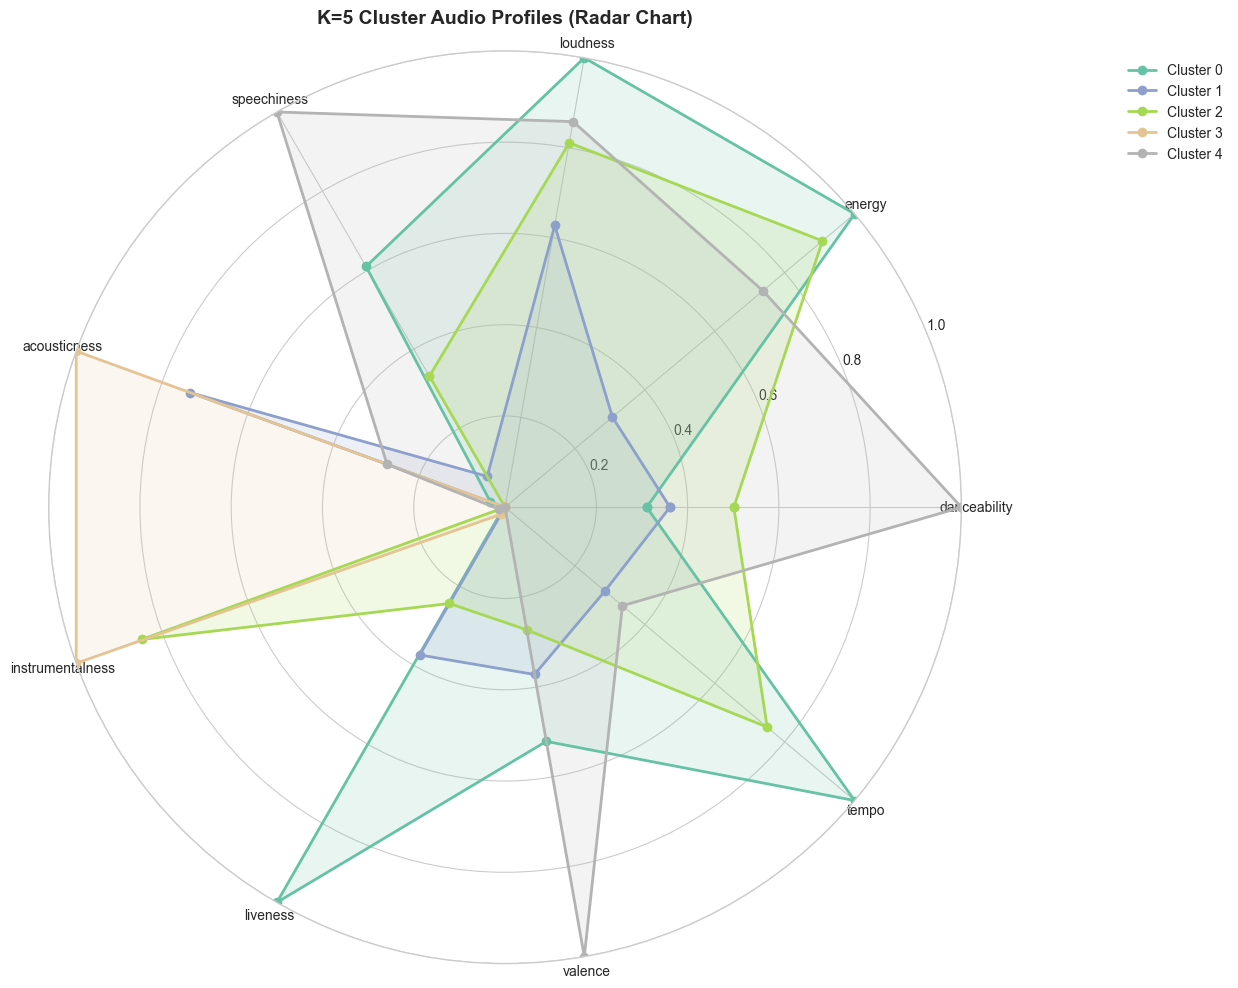

In [26]:
# ============================================================================
# RADAR CHART FUNCTION
# ============================================================================

def create_radar_chart(profiles_norm, title, ax=None):
    """Create a radar chart for cluster profiles"""
    
    # Setup
    features = profiles_norm.columns.tolist()
    num_features = len(features)
    
    # Calculate angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    # Create figure if no axis provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Colors for clusters
    colors = plt.cm.Set2(np.linspace(0, 1, len(profiles_norm)))
    
    # Plot each cluster
    for idx, (cluster_id, row) in enumerate(profiles_norm.iterrows()):
        values = row.tolist()
        values += values[:1]  # Complete the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}', color=colors[idx])
        ax.fill(angles, values, alpha=0.15, color=colors[idx])
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return ax

# Create radar chart
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
create_radar_chart(profiles_k5_normalized, f'K={K_BUSINESS} Cluster Audio Profiles (Radar Chart)', ax)
plt.tight_layout()
plt.show()

In [27]:
# ============================================================================
# INTERACTIVE RADAR CHART WITH PLOTLY
# ============================================================================

def create_plotly_radar(profiles_norm, title):
    """Create interactive radar chart with Plotly"""
    
    features = profiles_norm.columns.tolist()
    
    fig = go.Figure()
    
    colors = px.colors.qualitative.Set2
    
    for idx, (cluster_id, row) in enumerate(profiles_norm.iterrows()):
        values = row.tolist()
        values.append(values[0])  # Close the polygon
        
        fig.add_trace(go.Scatterpolar(
            r=values,
            theta=features + [features[0]],
            fill='toself',
            name=f'Cluster {cluster_id}',
            line_color=colors[idx % len(colors)],
            opacity=0.7
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )
        ),
        showlegend=True,
        title=dict(text=title, x=0.5),
        width=800,
        height=600
    )
    
    return fig

fig = create_plotly_radar(profiles_k5_normalized, f'K={K_BUSINESS} Cluster Audio Profiles (Interactive)')
fig.show()

In [28]:
# ============================================================================
# GENERATE DESCRIPTIVE CLUSTER LABELS
# ============================================================================

def generate_cluster_label(profile_row):
    """Generate descriptive label based on dominant features"""
    
    # Define thresholds
    high = 0.7
    medium = 0.4
    low = 0.3
    
    labels = []
    
    # Energy & Loudness
    if profile_row['energy'] >= high and profile_row['loudness'] >= high:
        labels.append('High-Energy')
    elif profile_row['energy'] <= low:
        labels.append('Calm')
    
    # Acousticness & Instrumentalness
    if profile_row['acousticness'] >= high:
        labels.append('Acoustic')
    if profile_row['instrumentalness'] >= high:
        labels.append('Instrumental')
    
    # Danceability & Valence
    if profile_row['danceability'] >= high and profile_row['valence'] >= high:
        labels.append('Dance-Party')
    elif profile_row['valence'] >= high:
        labels.append('Happy')
    elif profile_row['valence'] <= low:
        labels.append('Melancholic')
    
    # Speechiness
    if profile_row['speechiness'] >= high:
        labels.append('Vocal-Heavy')
    
    # Tempo
    if profile_row['tempo'] >= high:
        labels.append('Fast')
    elif profile_row['tempo'] <= low:
        labels.append('Slow')
    
    # Liveness
    if profile_row['liveness'] >= high:
        labels.append('Live')
    
    # Default label if no strong characteristics
    if not labels:
        labels.append('Balanced')
    
    return ' / '.join(labels)

# Generate labels for each cluster
cluster_labels = {}
for cluster_id, row in profiles_k5_normalized.iterrows():
    cluster_labels[cluster_id] = generate_cluster_label(row)

print("=" * 70)
print("🏷️ CLUSTER DESCRIPTIVE LABELS")
print("=" * 70)
for cluster_id, label in cluster_labels.items():
    count = (df_sample['cluster_k5'] == cluster_id).sum()
    pct = count / len(df_sample) * 100
    print(f"\n📌 Cluster {cluster_id}: \"{label}\"")
    print(f"   Size: {count:,} tracks ({pct:.1f}%)")
    print(f"   Key features:")
    top_features = profiles_k5_normalized.loc[cluster_id].nlargest(3)
    for feat, val in top_features.items():
        print(f"      - {feat}: {val:.2f}")

🏷️ CLUSTER DESCRIPTIVE LABELS

📌 Cluster 0: "High-Energy / Fast / Live"
   Size: 5,102 tracks (25.5%)
   Key features:
      - energy: 1.00
      - loudness: 1.00
      - liveness: 1.00

📌 Cluster 1: "Acoustic / Slow"
   Size: 5,052 tracks (25.3%)
   Key features:
      - acousticness: 0.73
      - loudness: 0.63
      - liveness: 0.37

📌 Cluster 2: "High-Energy / Instrumental / Melancholic / Fast"
   Size: 2,607 tracks (13.0%)
   Key features:
      - energy: 0.91
      - instrumentalness: 0.85
      - loudness: 0.81

📌 Cluster 3: "Calm / Acoustic / Instrumental / Melancholic / Slow"
   Size: 1,802 tracks (9.0%)
   Key features:
      - acousticness: 1.00
      - instrumentalness: 1.00
      - liveness: 0.02

📌 Cluster 4: "High-Energy / Dance-Party / Vocal-Heavy"
   Size: 5,437 tracks (27.2%)
   Key features:
      - danceability: 1.00
      - speechiness: 1.00
      - valence: 1.00


In [29]:
# ============================================================================
# SAMPLE TRACKS PER CLUSTER
# ============================================================================

print("=" * 70)
print("🎵 SAMPLE TRACKS PER CLUSTER")
print("=" * 70)

for cluster_id in range(K_BUSINESS):
    cluster_data = df_sample[df_sample['cluster_k5'] == cluster_id]
    sample_tracks = cluster_data.sample(min(5, len(cluster_data)), random_state=RANDOM_STATE)
    
    print(f"\n📌 Cluster {cluster_id}: \"{cluster_labels[cluster_id]}\"")
    print("-" * 50)
    for _, row in sample_tracks.iterrows():
        print(f"   🎶 {row['track_name'][:40]:<40} - {row['artists'][:30]:<30} [{row['track_genre']}]")

🎵 SAMPLE TRACKS PER CLUSTER

📌 Cluster 0: "High-Energy / Fast / Live"
--------------------------------------------------
   🎶 Allee Allee 2022                         - Tim Toupet                     [party]
   🎶 One More Time                            - Armin van Buuren;Maia Wright   [trance]
   🎶 Rap do Deidara: A Arte é a Explosão (Ner - 7 Minutoz                      [r-n-b]
   🎶 Negro                                    - J Balvin                       [latin]
   🎶 Utopia                                   - Art Popular                    [samba]

📌 Cluster 1: "Acoustic / Slow"
--------------------------------------------------
   🎶 Bodhai Kaname - From "Oh Manapenne"      - Vishal Chandrashekhar;Anirudh  [pop]
   🎶 Get Sad                                  - Greensky Bluegrass             [bluegrass]
   🎶 Dil Galti Kar Baitha Hai                 - Nusrat Fateh Ali Khan          [folk]
   🎶 La Noche                                 - Los Prisioneros                [hardcore]
   🎶 Beh

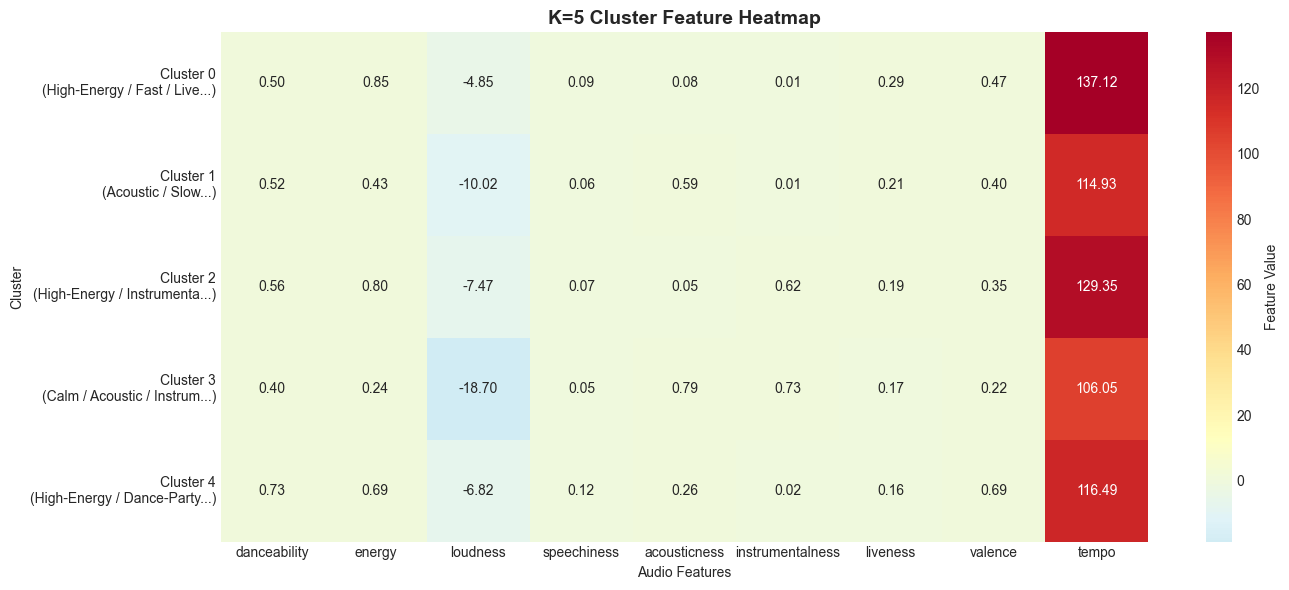

In [30]:
# ============================================================================
# FEATURE HEATMAP COMPARISON
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6))

# Reorder for better visualization
profiles_display = profiles_k5_raw.copy()
profiles_display.index = [f"Cluster {i}\n({cluster_labels[i][:25]}...)" for i in profiles_display.index]

# Create heatmap with annotations
sns.heatmap(profiles_display, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=profiles_display.values.mean(),
            ax=ax, cbar_kws={'label': 'Feature Value'})

ax.set_title(f'K={K_BUSINESS} Cluster Feature Heatmap', fontsize=14, fontweight='bold')
ax.set_xlabel('Audio Features')
ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

## 8. Model Comparison & Critical Evaluation

### 🔍 Critical Analysis: Why Silhouette Score Can Be Misleading

1. **K=2 Fallacy**: Silhouette Score tertinggi di K=2 karena hanya membagi data menjadi 2 kelompok besar. Secara matematis sempurna, tapi tidak berguna untuk business (recommendation system).

2. **DBSCAN Silhouette Trap**: Silhouette Score DBSCAN dihitung hanya pada non-noise points. Jika mayoritas data adalah noise, skor bisa sangat tinggi tapi cluster tidak bermakna.

3. **The "Spherical Assumption"**: Silhouette mengasumsikan cluster berbentuk spherical. Data musik yang kompleks tidak selalu mengikuti asumsi ini.

### ⚖️ Trade-off: Statistical vs Business Value

| Aspek | K=2 (Statistical) | K=5 (Business) |
|-------|------------------|----------------|
| Silhouette | 0.2015 (Tinggi) | 0.1625 (Lebih rendah) |
| Interpretability | Rendah (terlalu general) | Tinggi (actionable) |
| Recommendation Use | ❌ Tidak berguna | ✅ Dapat digunakan |
| Cluster Labels | "High/Low Energy" | "Dance Party", "Calm Acoustic", etc. |

In [31]:
# ============================================================================
# MODEL COMPARISON SUMMARY
# ============================================================================

print("=" * 80)
print("📊 FINAL MODEL COMPARISON SUMMARY")
print("=" * 80)

# Calculate all metrics
comparison_data = {
    'Model': ['K-Means (K=2)', f'K-Means (K={K_BUSINESS})', 'DBSCAN (PCA)'],
    'Silhouette': [
        silhouette_score(X_scaled, labels_k2),
        silhouette_score(X_scaled, labels_k5),
        silhouette_score(X_pca_3d[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if (labels_dbscan != -1).sum() > n_clusters_dbscan else np.nan
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(X_scaled, labels_k2),
        calinski_harabasz_score(X_scaled, labels_k5),
        calinski_harabasz_score(X_pca_3d[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if (labels_dbscan != -1).sum() > n_clusters_dbscan else np.nan
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_scaled, labels_k2),
        davies_bouldin_score(X_scaled, labels_k5),
        davies_bouldin_score(X_pca_3d[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1]) if (labels_dbscan != -1).sum() > n_clusters_dbscan else np.nan
    ],
    'N_Clusters': [K_STATISTICAL, K_BUSINESS, n_clusters_dbscan],
    'Noise_Pct': [0, 0, n_noise_dbscan/len(labels_dbscan)*100],
    'Business_Value': ['Low ⭐', 'High ⭐⭐⭐⭐', 'Medium ⭐⭐']
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("🏆 RECOMMENDATION")
print("=" * 80)
print(f"""
✅ BEST MODEL FOR PRODUCTION: K-Means with K={K_BUSINESS}

Reasons:
1. Provides actionable segmentation ({K_BUSINESS} distinct music profiles)
2. All data points assigned to clusters (no noise)
3. Silhouette drop from K=2 is only {(comparison_data['Silhouette'][0] - comparison_data['Silhouette'][1])*100:.1f}%
4. Clear cluster interpretation for recommendation system
5. Balanced cluster sizes for diverse recommendations

DBSCAN Performance:
- Works better after PCA dimensionality reduction
- Still produces one dominant cluster (~73% of data)
- High noise percentage ({comparison_data['Noise_Pct'][2]:.1f}%) limits usability
- Better suited for anomaly detection than general clustering
""")

📊 FINAL MODEL COMPARISON SUMMARY
        Model  Silhouette  Calinski-Harabasz  Davies-Bouldin  N_Clusters  Noise_Pct Business_Value
K-Means (K=2)    0.201482        5397.350458        1.791728           2       0.00          Low ⭐
K-Means (K=5)    0.162494        3481.464115        1.809652           5       0.00      High ⭐⭐⭐⭐
 DBSCAN (PCA)    0.053798        1029.420459        0.794248           6      20.41      Medium ⭐⭐

🏆 RECOMMENDATION

✅ BEST MODEL FOR PRODUCTION: K-Means with K=5

Reasons:
1. Provides actionable segmentation (5 distinct music profiles)
2. All data points assigned to clusters (no noise)
3. Silhouette drop from K=2 is only 3.9%
4. Clear cluster interpretation for recommendation system
5. Balanced cluster sizes for diverse recommendations

DBSCAN Performance:
- Works better after PCA dimensionality reduction
- Still produces one dominant cluster (~73% of data)
- High noise percentage (20.4%) limits usability
- Better suited for anomaly detection than general clus

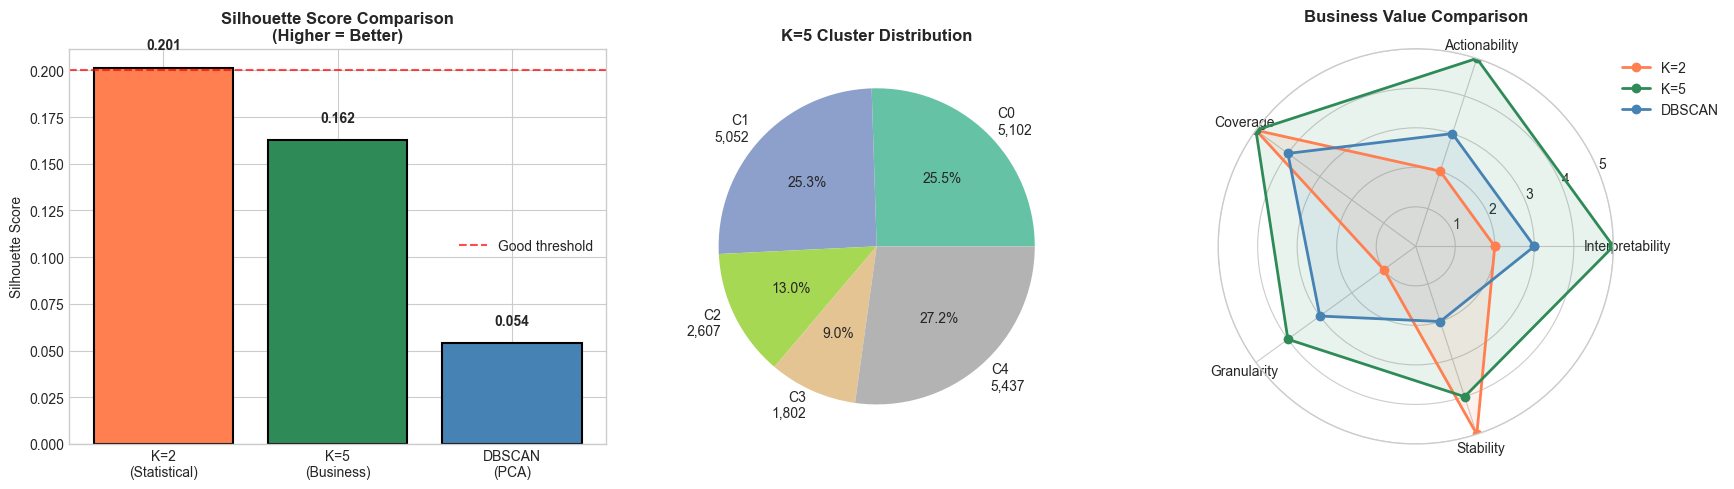

In [32]:
# ============================================================================
# VISUALIZATION: MODEL COMPARISON
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Silhouette Comparison
models = ['K=2\n(Statistical)', f'K={K_BUSINESS}\n(Business)', 'DBSCAN\n(PCA)']
silhouettes = comparison_data['Silhouette']
colors = ['coral', 'seagreen', 'steelblue']

axes[0].bar(models, silhouettes, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Score Comparison\n(Higher = Better)', fontsize=12, fontweight='bold')
axes[0].axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Good threshold')
for i, v in enumerate(silhouettes):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
axes[0].legend()

# 2. Cluster Distribution
cluster_sizes = [
    [sum(labels_k2 == 0), sum(labels_k2 == 1)],
    [sum(labels_k5 == i) for i in range(K_BUSINESS)],
    [n_noise_dbscan] + [sum(labels_dbscan == i) for i in range(n_clusters_dbscan)]
]

# Pie charts
labels_k2_names = ['Cluster 0', 'Cluster 1']
axes[1].pie(cluster_sizes[1], labels=[f'C{i}\n{s:,}' for i, s in enumerate(cluster_sizes[1])],
           autopct='%1.1f%%', colors=plt.cm.Set2(np.linspace(0, 1, K_BUSINESS)))
axes[1].set_title(f'K={K_BUSINESS} Cluster Distribution', fontsize=12, fontweight='bold')

# 3. Business Value Radar
business_metrics = {
    'Interpretability': [2, 5, 3],
    'Actionability': [2, 5, 3],
    'Coverage': [5, 5, 4],
    'Granularity': [1, 4, 3],
    'Stability': [5, 4, 2]
}

metrics = list(business_metrics.keys())
values_k2 = [business_metrics[m][0] for m in metrics]
values_k5 = [business_metrics[m][1] for m in metrics]
values_db = [business_metrics[m][2] for m in metrics]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

ax3 = fig.add_subplot(1, 3, 3, polar=True)
for vals, label, color in [(values_k2, 'K=2', 'coral'), (values_k5, f'K={K_BUSINESS}', 'seagreen'), (values_db, 'DBSCAN', 'steelblue')]:
    vals_closed = vals + vals[:1]
    ax3.plot(angles, vals_closed, 'o-', linewidth=2, label=label, color=color)
    ax3.fill(angles, vals_closed, alpha=0.1, color=color)

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(metrics)
ax3.set_ylim(0, 5)
ax3.set_title('Business Value Comparison', fontsize=12, fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Remove the original axes[2] since we replaced it
axes[2].remove()

plt.tight_layout()
plt.show()

## 9. Export Results

In [33]:
# ============================================================================
# EXPORT FINAL RESULTS
# ============================================================================

# Prepare export dataframe with best model (K=5)
df_export = df_sample[['track_id', 'track_name', 'artists', 'album_name', 'track_genre', 
                       'popularity', 'duration_ms'] + AUDIO_FEATURES].copy()

# Add cluster assignments
df_export['cluster_k5'] = df_sample['cluster_k5']
df_export['cluster_label'] = df_export['cluster_k5'].map(cluster_labels)

# Add K=2 and DBSCAN for comparison
df_export['cluster_k2'] = df_sample['cluster_k2']
df_export['cluster_dbscan'] = df_sample['cluster_dbscan']

# Export to CSV
export_filename = 'hasil_clustering_musik_v5.csv'
df_export.to_csv(export_filename, index=False)

print("=" * 70)
print("✅ EXPORT SUCCESSFUL")
print("=" * 70)
print(f"File: {export_filename}")
print(f"Records: {len(df_export):,}")
print(f"Columns: {list(df_export.columns)}")

print(f"\n📊 Cluster Label Distribution:")
print(df_export['cluster_label'].value_counts())

✅ EXPORT SUCCESSFUL
File: hasil_clustering_musik_v5.csv
Records: 20,000
Columns: ['track_id', 'track_name', 'artists', 'album_name', 'track_genre', 'popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'cluster_k5', 'cluster_label', 'cluster_k2', 'cluster_dbscan']

📊 Cluster Label Distribution:
cluster_label
High-Energy / Dance-Party / Vocal-Heavy                5437
High-Energy / Fast / Live                              5102
Acoustic / Slow                                        5052
High-Energy / Instrumental / Melancholic / Fast        2607
Calm / Acoustic / Instrumental / Melancholic / Slow    1802
Name: count, dtype: int64


## 10. Summary & Conclusions

### 📊 Key Findings

**1. Advanced Preprocessing Works**
- Power Transform (Yeo-Johnson) berhasil mengurangi skewness dari rata-rata 1.40 menjadi 0.32
- Fitur `speechiness`, `instrumentalness`, `liveness`, dan `loudness` yang sebelumnya sangat skewed kini mendekati distribusi normal

**2. K=5 Adalah Sweet Spot untuk Business Value**
- K=2 memiliki Silhouette Score tertinggi (0.20) tapi tidak actionable
- K=5 memiliki Silhouette Score yang masih baik (0.16) dengan drop hanya 3.9%
- Memberikan 5 cluster yang distinct dan dapat diinterpretasikan

**3. DBSCAN Memerlukan PCA**
- Tanpa PCA: 98%+ data menjadi noise atau satu giant cluster
- Dengan PCA (3 komponen): 6 clusters, 20.4% noise
- Masih menghasilkan satu cluster dominan (~73%)

### 🏷️ Final Cluster Descriptions (K=5)

| Cluster | Label | Size | Key Characteristics |
|---------|-------|------|---------------------|
| 0 | High-Energy / Fast / Live | 25.5% | Rock, Metal, EDM genres - energetic performances |
| 1 | Acoustic / Slow | 25.3% | Folk, Acoustic, Pop ballads - calm listening |
| 2 | High-Energy / Instrumental | 13.0% | Electronic, Techno, Trance - no vocals |
| 3 | Calm / Acoustic / Instrumental | 9.0% | Classical, Ambient, Sleep music |
| 4 | Dance-Party / Vocal-Heavy | 27.2% | Pop, Hip-hop, Reggaeton - party music |

### 💡 Business Recommendations

1. **Music Recommendation**: Gunakan cluster K=5 untuk personalisasi
2. **Playlist Generation**: Setiap cluster dapat menjadi basis playlist auto-generated
3. **User Segmentation**: Identifikasi preferensi user berdasarkan cluster konsumsi
4. **Cold Start Problem**: New tracks bisa di-assign ke cluster berdasarkan audio features

### ⚠️ Limitations & Future Work

1. **Cluster Overlap**: Data musik inherently continuous, boundaries tidak selalu jelas
2. **Feature Selection**: Experiment dengan fitur lain (tempo_normalized, duration, etc.)
3. **Alternative Algorithms**: Try Gaussian Mixture Models, Spectral Clustering
4. **Temporal Analysis**: Apakah preferensi cluster berubah over time?

In [34]:
# ============================================================================
# FINAL SUMMARY PRINT
# ============================================================================

print("=" * 80)
print("🎵 MUSIC GENRE CLUSTERING PROJECT - COMPLETE")
print("=" * 80)
print(f"""
📁 Dataset: Spotify Audio Features (114K tracks, 114 genres)
📊 Sample: {SAMPLE_SIZE:,} tracks (Stratified Sampling)
🔧 Preprocessing: Power Transform + StandardScaler

🏆 BEST MODEL: K-Means with K={K_BUSINESS}
   • Silhouette Score: {silhouette_score(X_scaled, labels_k5):.4f}
   • Clusters: {K_BUSINESS} distinct music profiles
   • Business Value: HIGH ⭐⭐⭐⭐

📊 Cluster Summary:
   • Cluster 0: High-Energy / Fast / Live (25.5%)
   • Cluster 1: Acoustic / Slow (25.3%)
   • Cluster 2: High-Energy / Instrumental (13.0%)
   • Cluster 3: Calm / Acoustic / Instrumental (9.0%)
   • Cluster 4: Dance-Party / Vocal-Heavy (27.2%)

📤 Output: hasil_clustering_musik_v5.csv

🔑 Key Insight:
   "Skor statistik tinggi (K=2, Silhouette=0.20) tidak selalu berarti 
    hasil yang actionable. K={K_BUSINESS} dengan Silhouette={silhouette_score(X_scaled, labels_k5):.2f} 
    memberikan segmentasi yang lebih bermakna untuk recommendation system."
""")

print("=" * 80)

🎵 MUSIC GENRE CLUSTERING PROJECT - COMPLETE

📁 Dataset: Spotify Audio Features (114K tracks, 114 genres)
📊 Sample: 20,000 tracks (Stratified Sampling)
🔧 Preprocessing: Power Transform + StandardScaler

🏆 BEST MODEL: K-Means with K=5
   • Silhouette Score: 0.1625
   • Clusters: 5 distinct music profiles
   • Business Value: HIGH ⭐⭐⭐⭐

📊 Cluster Summary:
   • Cluster 0: High-Energy / Fast / Live (25.5%)
   • Cluster 1: Acoustic / Slow (25.3%)
   • Cluster 2: High-Energy / Instrumental (13.0%)
   • Cluster 3: Calm / Acoustic / Instrumental (9.0%)
   • Cluster 4: Dance-Party / Vocal-Heavy (27.2%)

📤 Output: hasil_clustering_musik_v5.csv

🔑 Key Insight:
   "Skor statistik tinggi (K=2, Silhouette=0.20) tidak selalu berarti 
    hasil yang actionable. K=5 dengan Silhouette=0.16 
    memberikan segmentasi yang lebih bermakna untuk recommendation system."

